***ML opdracht 2***
# Voorspellen van Verhuuraantallen: Een Tijdreeksanalyse

In dit notebook doorloop ik het volledige proces van het voorspellen van uurlijkse verhuuraantallen. Ik begin met een grondige Exploratieve Data Analyse (EDA) om de data te begrijpen, gevolgd door feature engineering om de tijdreeks-specifieke patronen te vangen. Ten slotte zal ik verschillende modellen trainen en evalueren om tot de best mogelijke voorspelling te komen.

**door: Soner Yigitdol**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Hoofdstuk 1: Exploratieve Data Analyse (EDA)

De eerste en meest cruciale stap is de Exploratieve Data Analyse. Het doel van de EDA is om een diepgaand begrip van de dataset te krijgen. Ik zal de structuur van de data inspecteren, basisstatistieken bekijken, en de data visualiseren om patronen, relaties en eventuele afwijkingen te ontdekken. De inzichten die ik hier opdoe, vormen de basis voor de keuzes die ik later maak in het feature engineering- en modelleringsproces.

### 1.1. Data Inladen en Voorbereiden

Ik laad het `train.csv` bestand in en voer een essentiële voorbereidingsstap uit: het converteren van de `date_hour` kolom naar een `datetime` object en deze instellen als de index van de DataFrame. Dit is fundamenteel voor vrijwel alle tijdreeksanalyses.

In [3]:
df = pd.read_csv('train.csv')
df.index = pd.to_datetime(df['date_hour'])
df.drop(columns=['date_hour'], inplace=True)
df.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


In [4]:
df.head()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
date_hour,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


In [5]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     16637 non-null  int64  
 1   weathersit  16637 non-null  int64  
 2   temp        16637 non-null  float64
 3   atemp       16637 non-null  float64
 4   hum         16637 non-null  float64
 5   windspeed   16637 non-null  float64
 6   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.0 MB
None
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


### 1.2. Algemene Trends en Invloed van Categorieën (Vakantiedag & Seizoen)

Ik begin de visuele analyse met een "time plot" van de gehele dataset. Dit geeft een helicopterview van de algemene trend over de twee jaar.

Direct daarna zoom ik in op twee belangrijke categorische variabelen: `holiday` en `season`. Ik wil weten wat de gemiddelde impact is van een vakantiedag en hoe de verhuuraantallen verdeeld zijn over de vier seizoenen. Omdat de `season` kolom niet bestaat, maak ik deze zelf aan op basis van de maand.

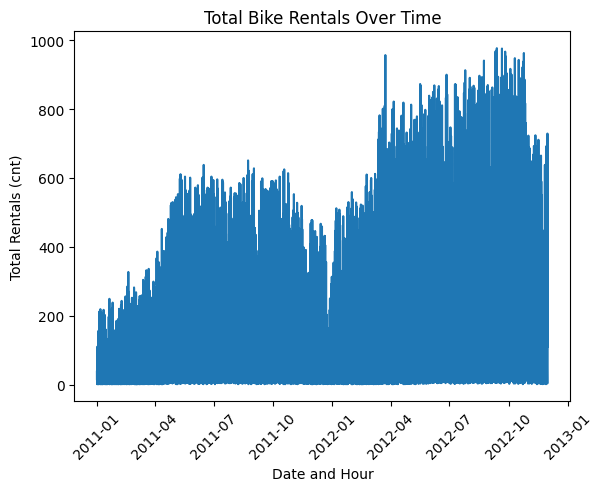

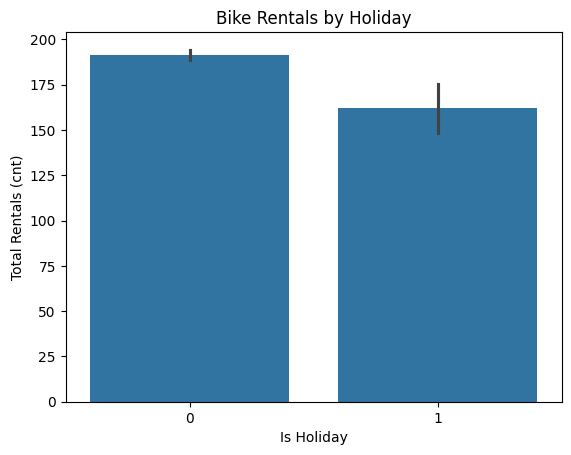

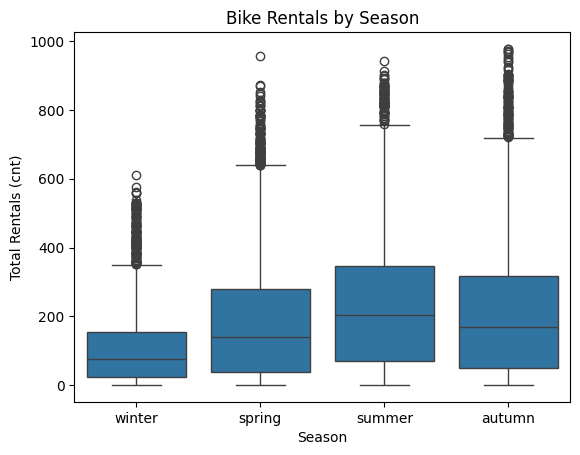

In [6]:
# Plot 1: Algemene trend van verhuringen over tijd
sns.lineplot(x=df.index, y=df['cnt'])
plt.title('Total Bike Rentals Over Time')
plt.xlabel('Date and Hour')
plt.ylabel('Total Rentals (cnt)')
plt.xticks(rotation=45)
plt.show()

# Plot 2: Vergelijking van verhuringen op werkdagen vs. vakantiedagen
sns.barplot(x='holiday', y='cnt', data=df)
plt.title('Bike Rentals by Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Total Rentals (cnt)')
plt.show()

# Plot 3: Verhuringen per seizoen
# 'season' bestaat niet in df, dus maken we deze afgeleid van de datumindex (maand -> seizoen)
df_plot = df.copy()
df_plot['month'] = df_plot.index.month

def month_to_season(m):
	if m in (12, 1, 2):
		return 'winter'
	elif m in (3, 4, 5):
		return 'spring'
	elif m in (6, 7, 8):
		return 'summer'
	else:
		return 'autumn'

df_plot['season'] = df_plot['month'].apply(month_to_season)

order = ['winter', 'spring', 'summer', 'autumn']
sns.boxplot(x='season', y='cnt', data=df_plot, order=order)
plt.title('Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Total Rentals (cnt)')
plt.show()


**Bevindingen:**

*   **Algemene Trend:** De eerste grafiek toont een duidelijke seizoenscyclus (laag in de winter, hoog in de zomer) en een opwaartse trend, waarbij het aantal verhuringen in 2012 aanzienlijk hoger ligt dan in 2011.

*   **Invloed van Vakantiedagen:** De staafdiagram laat zien dat er op een normale werkdag (`holiday=0`) gemiddeld meer fietsen worden verhuurd dan op een vakantiedag (`holiday=1`). Dit komt waarschijnlijk doordat de pieken van het woon-werkverkeer wegvallen, wat het dagelijks gemiddelde drukt.

*   **Verdeling per Seizoen:** De boxplot geeft een zeer helder beeld van de seizoensinvloeden.
    *   **Winter:** Heeft de laagste mediaan en de kleinste spreiding. De vraag is consistent laag.
    *   **Lente & Herfst:** De vraag is aanzienlijk hoger dan in de winter en de spreiding is groter.
    *   **Zomer:** Heeft de hoogste mediaan en de grootste spreiding in verhuuraantallen. De vele uitschieters (`outliers`) aan de bovenkant duiden op extreem drukke dagen, waarschijnlijk veroorzaakt door perfect weer.

### 1.3. Analyse van Maandelijkse, Wekelijkse en Dagelijkse Patronen

Nadat ik het algemene beeld en de invloed van vakantiedagen en seizoenen heb bekeken, is het nu tijd om nog dieper in te zoomen op de verschillende tijdschalen: de maand, de week en de dag. Hiervoor gebruik ik lijnplots, die het gemiddelde aantal verhuringen tonen en een goed beeld geven van de trends binnen deze periodes.

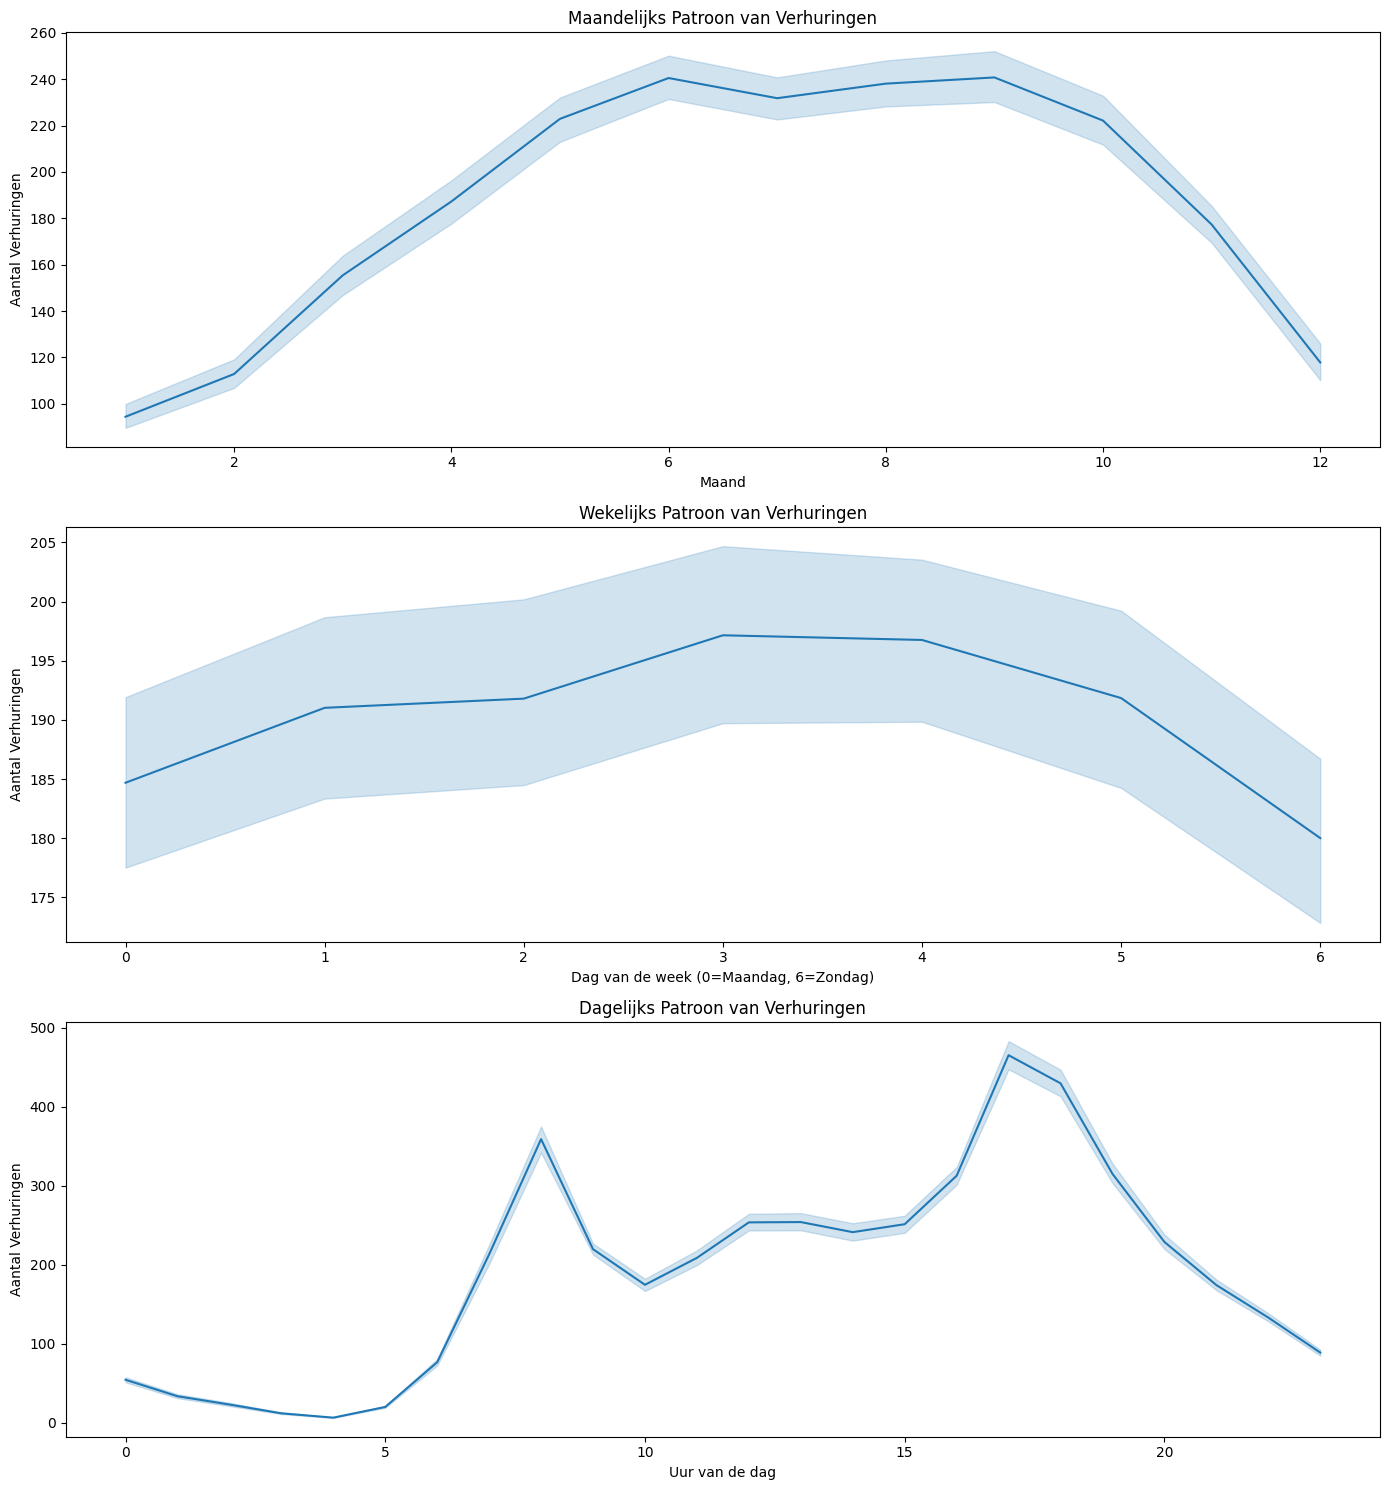

In [7]:
df_train = df.copy()

# DatetimeIndex doesn't have .dt accessor; use the DatetimeIndex attributes directly
df_train['month'] = df_train.index.month
df_train['hour'] = df_train.index.hour
df_train['dayofweek'] = df_train.index.dayofweek  # Maandag=0, Zondag=6

fig, axes = plt.subplots(3, 1, figsize=(14, 15))

# Maandelijks patroon
sns.lineplot(x='month', y='cnt', data=df_train, ax=axes[0])
axes[0].set_title('Maandelijks Patroon van Verhuringen')
axes[0].set_xlabel('Maand')
axes[0].set_ylabel('Aantal Verhuringen')

# Wekelijks patroon
sns.lineplot(x='dayofweek', y='cnt', data=df_train, ax=axes[1])
axes[1].set_title('Wekelijks Patroon van Verhuringen')
axes[1].set_xlabel('Dag van de week (0=Maandag, 6=Zondag)')
axes[1].set_ylabel('Aantal Verhuringen')

# Dagelijks patroon (per uur)
sns.lineplot(x='hour', y='cnt', data=df_train, ax=axes[2])
axes[2].set_title('Dagelijks Patroon van Verhuringen')
axes[2].set_xlabel('Uur van de dag')
axes[2].set_ylabel('Aantal Verhuringen')

plt.tight_layout()
plt.show()

**Bevindingen:**

Deze gedetailleerde plots onthullen de kernpatronen van de data:

*   **Maandelijks Patroon:** Deze grafiek bevestigt de seizoensplot uit de vorige sectie. Het toont een vloeiende curve met een dieptepunt in de winter (januari/februari) en een duidelijke piek in de warmere zomermaanden (juni t/m september).

*   **Wekelijks Patroon:** We zien dat de vraag gedurende de werkweek (maandag t/m vrijdag) relatief hoog en stabiel is. In het weekend (zaterdag en zondag) daalt het gemiddelde aantal verhuringen.

*   **Dagelijks Patroon:** Dit is de meest onthullende grafiek. Het toont een zeer sterk **bimodaal patroon**, wat betekent dat er twee pieken zijn:
    *   Een scherpe **ochtendpiek rond 8:00 uur**.
    *   Een nog hogere en bredere **avondpiek rond 17:00 en 18:00 uur**.
    
    Dit patroon is een klassiek voorbeeld van **woon-werkverkeer**. Gedurende de nachtelijke uren (ca. 00:00 tot 05:00) is de vraag nagenoeg nul. Deze uur-informatie zal extreem belangrijk zijn voor het voorspellende model.

#### 1.4. Invloed van Externe Factoren: Weer en Context

Naast de voorspelbare patronen in tijd, wordt de vraag naar huurfietsen sterk beïnvloed door externe omstandigheden. In deze sectie onderzoek ik de impact van twee belangrijke contextuele variabelen: de weersituatie (`weathersit`) en of het een vakantiedag is (`holiday`). Ik gebruik boxplots om een goed beeld te krijgen van de verdeling, de mediaan en de uitschieters voor elke categorie.


C:\Users\soner\AppData\Local\Temp\ipykernel_22128\2089207865.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['1: Helder', '2: Mistig', '3: Lichte Neerslag', '4: Zware Neerslag'])
C:\Users\soner\AppData\Local\Temp\ipykernel_22128\2089207865.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Werkdag', 'Vakantiedag'])


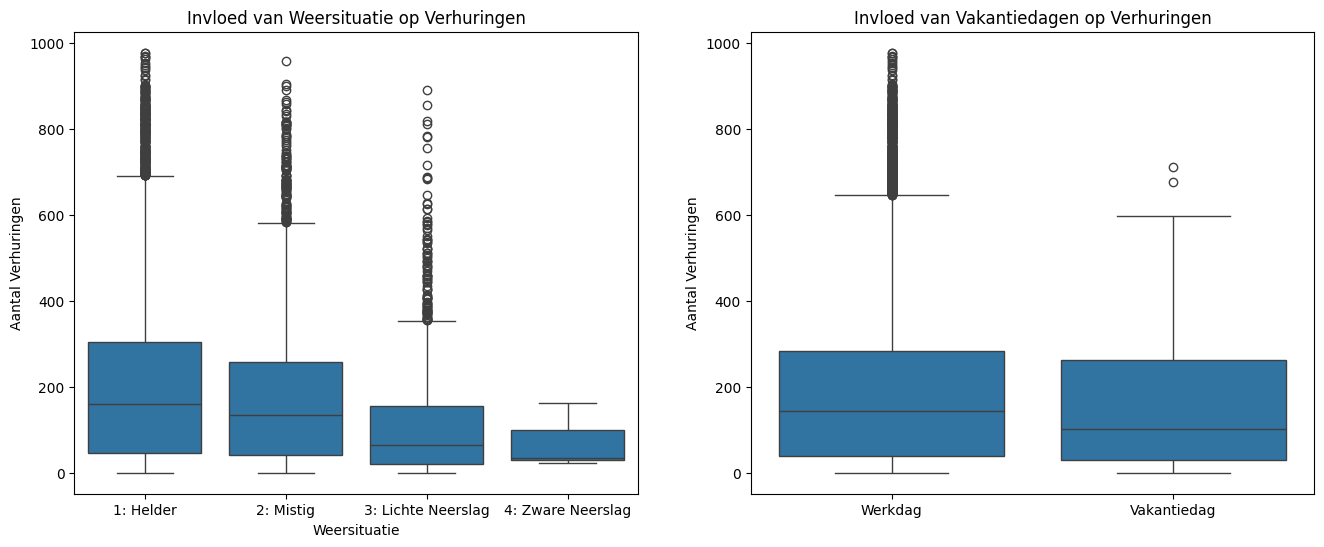

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Invloed van weersituatie
sns.boxplot(x='weathersit', y='cnt', data=df_train, ax=axes[0])
axes[0].set_title('Invloed van Weersituatie op Verhuringen')
axes[0].set_xlabel('Weersituatie')
axes[0].set_ylabel('Aantal Verhuringen')
axes[0].set_xticklabels(['1: Helder', '2: Mistig', '3: Lichte Neerslag', '4: Zware Neerslag'])

# Invloed van vakantiedag
sns.boxplot(x='holiday', y='cnt', data=df_train, ax=axes[1])
axes[1].set_title('Invloed van Vakantiedagen op Verhuringen')
axes[1].set_xlabel('')
axes[1].set_ylabel('Aantal Verhuringen')
axes[1].set_xticklabels(['Werkdag', 'Vakantiedag'])

plt.show()

**Bevindingen:**

*   **Invloed van Weersituatie:** Dit is een van de meest invloedrijke variabelen. De boxplot laat een duidelijke, negatieve relatie zien: hoe slechter het weer, hoe lager de vraag.
    *   Bij **helder weer** (`1`) is de mediaan het hoogst en is de spreiding (de grootte van de 'box') ook het grootst. De vele uitschieters naar boven duiden op uitzonderlijk drukke dagen.
    *   Bij **mistig weer** (`2`) en **lichte neerslag** (`3`) daalt de mediaan aanzienlijk.
    *   Bij **zware neerslag** (`4`) is de vraag minimaal, wat volkomen logisch is.

*   **Invloed van Vakantiedagen:** De mediaan van het aantal verhuringen op een **Werkdag** is hoger dan op een **Vakantiedag**. Dit bevestigt onze eerdere conclusie: het wegvallen van de forensenpieken op vakantiedagen heeft een drukkend effect op het totale aantal verhuringen, ook al kan het recreatieve gebruik gedurende de dag toenemen.

### 1.5. Correlatie Tussen Numerieke Variabelen

Als laatste stap in de EDA kwantificeer ik de lineaire relaties tussen de numerieke variabelen met behulp van een correlatiematrix. Een heatmap is de perfecte manier om dit te visualiseren. Dit helpt mij om snel te zien welke variabelen het sterkst samenhangen met het aantal verhuringen (`cnt`) en, nog belangrijker, om **multicollineariteit** (een te sterke correlatie tussen onafhankelijke variabelen) te detecteren.

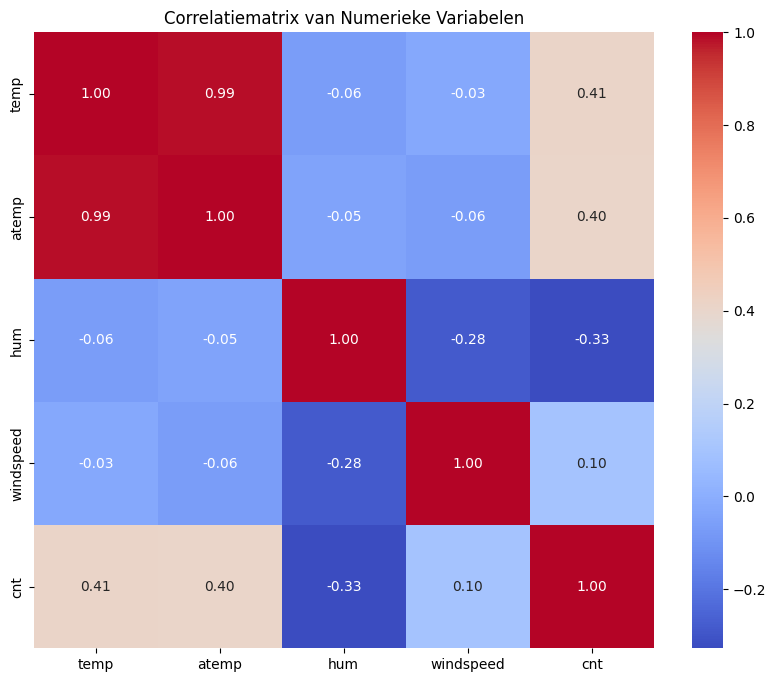

In [9]:
numeric_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Bereken de correlatiematrix
correlation_matrix = df_train[numeric_cols].corr()

# Plot de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlatiematrix van Numerieke Variabelen')
plt.show()

**Bevindingen:**

De heatmap geeft een aantal duidelijke inzichten:

*   **Temperatuur (`temp` & `atemp`):** Beide temperatuurmaten hebben een sterke positieve correlatie (respectievelijk 0.41 en 0.40) met het aantal verhuringen. Dit is de sterkste relatie onder de weersvariabelen en bevestigt: hoe warmer het is, hoe meer mensen een fiets huren.

*   **Luchtvochtigheid (`hum`):** Deze variabele heeft een redelijk sterke negatieve correlatie (-0.33) met `cnt`. Dit betekent dat bij een hogere luchtvochtigheid (wat vaak geassocieerd wordt met regen of benauwdheid) de vraag afneemt.

*   **Windsnelheid (`windspeed`):** De correlatie met `cnt` is zwak positief (0.10). Hardere wind heeft dus een licht positief effect, maar deze relatie is veel minder sterk dan die van temperatuur en luchtvochtigheid.

*   **!! Multicollineariteit !!:** De meest opvallende waarde in de matrix is de correlatie van **0.99** tussen `temp` (temperatuur) en `atemp` (gevoelstemperatuur). Deze twee variabelen meten nagenoeg hetzelfde. Het meenemen van beide variabelen in een model (vooral lineaire modellen) kan leiden tot instabiliteit en onbetrouwbare resultaten. Daarom is het essentieel om hier een keuze te maken. Ik zal ervoor kiezen om `temp` te verwijderen en alleen `atemp` te behouden, omdat de gevoelstemperatuur waarschijnlijk een betere representatie is van de factor die het gedrag van mensen beïnvloedt.

### 1.6. Vergelijking van Additieve en Multiplicatieve Decompositie

Als laatste stap van de EDA voer ik een tijdreeksdecompositie uit. Deze techniek splitst de tijdreeks wiskundig op in zijn drie fundamentele componenten: **Trend**, **Seizoen** en **Residu**. Dit is een krachtige manier om de structuur van de data te visualiseren.

Ik vergelijk de twee hoofdtypen decompositie:
- **Additief:** Gaat ervan uit dat de seizoensinvloeden een constante grootte hebben (`cnt = Trend + Season + Resid`).
- **Multiplicatief:** Gaat ervan uit dat de seizoensinvloeden meegroeien met de trend (`cnt = Trend * Season * Resid`).

Omdat de schommelingen in 2012 groter lijken dan in 2011, verwacht ik dat een multiplicatief model beter past. Ik visualiseer beide om dit te verifiëren. De beste fit wordt gekenmerkt door een residu dat zo veel mogelijk op willekeurige ruis lijkt, zonder duidelijke patronen.

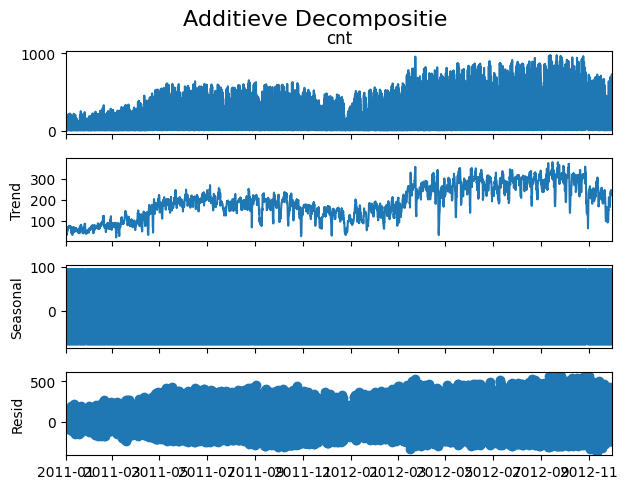

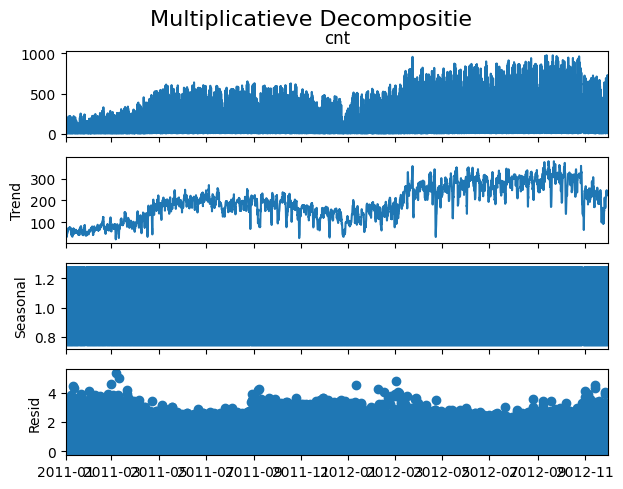

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# De periode is 24 omdat we het sterke dagelijkse patroon willen isoleren.
PERIOD = 24

# Multiplicatieve decompositie werkt niet met 0-waardes.
# We voegen een kleine constante (1) toe om dit te voorkomen.
decomposed_series = df_train['cnt'] + 1

# --- Additieve Decompositie ---
result_add = seasonal_decompose(decomposed_series, model='additive', period=PERIOD)
fig_add = result_add.plot()
fig_add.suptitle('Additieve Decompositie', y=1.01, fontsize=16)
plt.show()

# --- Multiplicatieve Decompositie ---
result_mul = seasonal_decompose(decomposed_series, model='multiplicative', period=PERIOD)
fig_mul = result_mul.plot()
fig_mul.suptitle('Multiplicatieve Decompositie', y=1.01, fontsize=16)
plt.show()

**Bevindingen en Keuze:**

Bij het vergelijken van de twee decomposities, kijk ik voornamelijk naar de **Residu (`Resid`)** plots. Een beter model zal residuen produceren die meer op willekeurige ruis lijken, zonder duidelijke patronen.

-   **Trend & Seizoen:** In beide plots worden de trend (langetermijngroei) en het seizoen (zeer regelmatig dagelijks patroon) goed geïsoleerd en zien ze er vergelijkbaar uit.
-   **Additieve Residu:** In de residuen van het additieve model is een duidelijk "waaier" patroon (heteroscedasticiteit) zichtbaar. De variantie van de residuen is in 2011 (links) aanzienlijk kleiner dan in 2012 (rechts). Dit betekent dat het model niet alle seizoensdynamiek heeft kunnen vangen en de fouten groter worden naarmate de trend toeneemt.
-   **Multiplicatieve Residu:** De residuen van het multiplicatieve model zijn veel consistenter in variantie over de gehele periode. De schommelingen zijn meer gelijkmatig verdeeld rond de 1.0-lijn van begin tot eind. Er is geen duidelijk waaierpatroon zichtbaar.

**Conclusie:** Het **multiplicatieve model** is een significant betere fit voor deze data. Dit bevestigt onze hypothese dat de seizoensschommelingen (de dagelijkse pieken en dalen) proportioneel meegroeien met de algehele trend in populariteit. Dit inzicht is waardevol voor de modelkeuze in Hoofdstuk 3 en suggereert dat modellen die multiplicatieve effecten kunnen vangen (zoals tree-based modellen) of het toepassen van een log-transformatie op de doelvariabele goede strategieën zullen zijn.


### 1.7. Hoofdconclusies van de Exploratieve Data Analyse

Na een grondige visuele en statistische analyse van de data, zijn dit de belangrijkste bevindingen die als leidraad zullen dienen voor de rest van het project:

1.  **De Data wordt gedreven door Meerdere Tijdspatronen:** Er is sprake van een duidelijke **opwaartse trend** (meer verhuringen in 2012 dan in 2011) en zeer sterke, voorspelbare **seizoenspatronen** op meerdere niveaus:
    *   **Jaarlijks:** Een piek in de zomer en een dal in de winter.
    *   **Wekelijks:** Stabiele vraag tijdens werkdagen, met een lichte daling in het weekend.
    *   **Dagelijks:** Een dominant woon-werkverkeerpatroon met pieken om 8:00 en 17:00-18:00 uur.

2.  **Externe Factoren zijn Cruciaal:**
    *   **Weer:** Gevoelstemperatuur (`atemp`) en de algemene weersituatie (`weathersit`) zijn zeer sterke voorspellers. Goed weer stimuleert de vraag aanzienlijk.
    *   **Context:** Op vakantiedagen (`holiday`) is de gemiddelde vraag lager, waarschijnlijk door het wegvallen van de forensenpieken.

3.  **De Relaties zijn Multiplicatief:** De decompositie-analyse toonde overtuigend aan dat de seizoensschommelingen meegroeien met de trend. Dit suggereert dat modellen die multiplicatieve effecten kunnen vangen, of het toepassen van een log-transformatie op de doelvariabele, effectieve strategieën zullen zijn.

4.  **Data Opschoning is Nodig:** De feature `temp` moet worden verwijderd om multicollineariteit met `atemp` (correlatie van 0.99) te voorkomen. `atemp` wordt behouden als de meest relevante temperatuurmaat.

Deze inzichten vormen de directe input voor **Hoofdstuk 2: Feature Engineering**, waar we deze patronen en relaties zullen omzetten in concrete, numerieke features voor onze voorspellende modellen.

# Hoofdstuk 2: Time Series Feature Engineering

De Exploratieve Data Analyse heeft ons een diepgaand inzicht gegeven in de patronen van de verhuurdata. We zagen een duidelijke trend, sterke seizoensinvloeden en specifieke dagelijkse cycli. Een machine learning model kan deze patronen echter niet direct uit een `datetime` object leren.

Het doel van dit hoofdstuk is om deze temporele informatie te "vertalen" naar numerieke features die een model wél kan begrijpen. We zullen de dataset stapsgewijs verrijken met features die de geïdentificeerde patronen expliciet maken, conform de eisen van de opdracht.

### 2.1. Voorbereidende Stappen

Voordat we beginnen met het creëren van nieuwe features, voeren we eerst de opschoningsstap uit die we in de EDA hebben geïdentificeerd: het verwijderen van de `temp` kolom om multicollineariteit met `atemp` te voorkomen. We maken een kopie van de originele dataframes om de oorspronkelijke data intact te laten.

In [11]:
df_train = df_train.drop('temp', axis=1)
print("Kolommen na verwijderen van 'temp':")
print(df_train.columns)

Kolommen na verwijderen van 'temp':
Index(['holiday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt', 'month',
       'hour', 'dayofweek'],
      dtype='object')


### 2.2. Onderzoek naar Trends en Tijdgebaseerde Features

**Trend:** De EDA toonde een duidelijke opwaartse trend van 2011 naar 2012. Een eenvoudige manier om dit te modelleren is door een "tijdstap" feature te creëren die simpelweg oploopt. Dit stelt een lineair model in staat om een algemene groei over tijd te leren.

**Andere Tijdgebaseerde Features:** We zagen ook sterke patronen gebaseerd op het uur, de dag van de week en de maand. We extraheren deze direct uit de `datetime` index.

In [12]:
def create_time_features(df):
    """
    Creëert basis tijd-features en een trend-feature.
    """
    df = df.copy()
    # Basis tijd-features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    # Trend feature (simpele tijdstap)
    df['timestep'] = range(len(df))
    
    return df

X_train = create_time_features(df_train)

print("Voorbeeld van de nieuwe tijd-features:")
display(X_train[['hour', 'dayofweek', 'month', 'year', 'timestep']].head())

Voorbeeld van de nieuwe tijd-features:


,hour,dayofweek,month,year,timestep
date_hour,,,,,
2011-01-01 00:00:00,0,5,1,2011,0
2011-01-01 01:00:00,1,5,1,2011,1
2011-01-01 02:00:00,2,5,1,2011,2
2011-01-01 03:00:00,3,5,1,2011,3
2011-01-01 04:00:00,4,5,1,2011,4


### 2.3. Onderzoek naar Seizoenspatronen met Periodogram (Fourier Analyse)

Voordat ik specifieke seizoensfeatures creëer, wil ik de dominante cycli in de data objectief vaststellen. De opdracht vereist expliciet een Fourier-analyse, en de meest effectieve manier om dit te doen is met een **periodogram**.

Een periodogram toont de "kracht" (of variantie) van verschillende frequenties in de tijdreeks. Grote pieken in de grafiek duiden op belangrijke, terugkerende patronen (seizoenen of cycli). Dit stelt mij in staat om te bepalen welke seizoensinvloeden het belangrijkst zijn om te modelleren. Ik analyseer de `cnt` kolom van de trainingsdata.

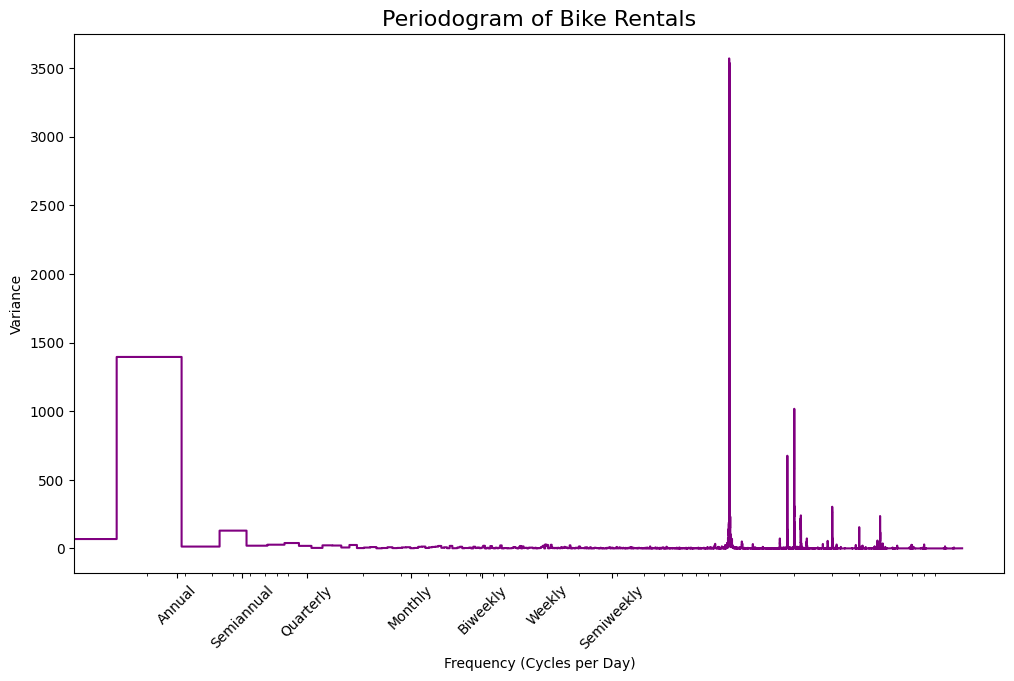

In [13]:
# Importeer de benodigde functie
from scipy.signal import periodogram

# Definieer de frequentie van onze data (uurlijks)
# 1 dag = 24 uur, 1 jaar = 365.25 * 24 uur
fs = 24 # We gebruiken 24 samples per dag als basis sampling frequency

# Bereken het periodogram
frequencies, spectrum = periodogram(
    df_train['cnt'],
    fs=fs,
    detrend='linear', # Verwijder de algemene trend voor een duidelijker beeld
    window="boxcar",
    scaling='spectrum',
)

# Functie om de frequenties om te zetten naar leesbare labels
def freq_to_label(freq):
    if freq == 0: return "Static"
    period = 1 / freq
    if period > 300: return "Annual"
    if period > 150: return "Semiannual"
    if period > 80: return "Quarterly"
    if period > 25: return "Monthly"
    if period > 10: return "Biweekly"
    if abs(period - 7) < 0.1: return "Weekly"
    if abs(period - 3.5) < 0.1: return "Semiweekly"
    return None

# Plot het periodogram
plt.figure(figsize=(12, 7))
plt.step(frequencies, spectrum, color="purple")
plt.xscale("log") # Logaritmische schaal maakt de lagere frequenties beter zichtbaar
plt.xticks(rotation=45)
plt.xlabel("Frequency (Cycles per Day)")
plt.ylabel("Variance")
plt.title("Periodogram of Bike Rentals", fontsize=16)

# Voeg leesbare labels toe
tick_freqs = [1/365, 1/182, 1/91, 1/30, 1/(2*7), 1/7, 2/7]
tick_labels = ['Annual', 'Semiannual', 'Quarterly', 'Monthly', 'Biweekly', 'Weekly', 'Semiweekly']
plt.xticks(ticks=tick_freqs, labels=tick_labels)

plt.show()

**Bevindingen uit het Periodogram:**

De grafiek is overduidelijk en bevestigt de patronen uit de EDA op een wiskundige manier:

*   **Weekly (Wekelijks):** Er is een **enorme piek** bij de wekelijkse frequentie (en de harmonischen daarvan, zoals de half-wekelijkse). Dit is veruit het meest dominante patroon in de data. Het onderscheid tussen werkdagen en weekend is de belangrijkste drijfveer van de vraag.
*   **Annual & Semiannual (Jaarlijks & Halfjaarlijks):** Er zijn ook duidelijke, brede pieken zichtbaar bij de langere periodes, die de overgang van de seizoenen (lente/zomer vs. herfst/winter) markeren.
*   **Daily (Dagelijks):** Rechts op de plot (bij de hogere frequenties) zien we een cluster van pieken rond de dagelijkse frequentie en zijn harmonischen (12-uurs, 8-uurs). Dit representeert de ochtend- en avondspits (het bimodale patroon).

Deze analyse geeft een sterke, data-gedreven rechtvaardiging voor de features die we nu gaan creëren. We moeten ons richten op het modelleren van de jaarlijkse, wekelijkse en dagelijkse cycli.

### 2.4. Creëren van Fourier Features en andere Tijd-Features

Gewapend met de kennis uit het periodogram, ga ik nu gericht features maken. Ik combineer de aanpak van `DeterministicProcess` voor de langere cycli met handmatige feature-creatie voor de kortere.

In [14]:
# We gebruiken de DeterministicProcess klasse voor een robuuste aanpak
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

# 1. Definieer de Fourier termen voor de langere cycli
# 'order' is het aantal sinus/cosinus paren. Een hogere order kan complexere curves leren.
fourier_yearly = CalendarFourier(freq='A', order=4)  # Jaarlijkse cyclus
fourier_weekly = CalendarFourier(freq='W', order=3)  # Wekelijkse cyclus

# 2. Stel het deterministische proces in
dp = DeterministicProcess(
    index=df_train.index,
    order=1,                          # Lineaire trend (t=1, 2, 3, ...)
    seasonal=False,
    additional_terms=[fourier_yearly, fourier_weekly],
    drop=True
)

# 3. Creëer de deterministische features
X_train_deterministic = dp.in_sample()

# 4. Voeg handmatig de dagelijkse cyclus en andere basis time-features toe
def create_daily_features(df):
    df = df.copy()
    # Dagelijkse cyclus met Fourier
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    # Categorische feature voor weekend
    df['is_weekend'] = ((df.index.dayofweek == 5) | (df.index.dayofweek == 6)).astype(int)
    return df

X_train_final = create_daily_features(X_train_deterministic)

print("Voorbeeld van de gecombineerde deterministische en Fourier features:")
display(X_train_final.head())

Voorbeeld van de gecombineerde deterministische en Fourier features:


c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


,trend,"sin(1,freq=YE-DEC)","cos(1,freq=YE-DEC)","sin(2,freq=YE-DEC)","cos(2,freq=YE-DEC)","sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",hour_sin,hour_cos,is_weekend
date_hour,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,0.000000,1.000000,1
2011-01-01 01:00:00,2.0,0.000717,1.000000,0.001435,0.999999,0.002152,0.999998,0.002869,0.999996,-0.982566,-0.185912,0.365341,-0.930874,0.846724,0.532032,0.258819,0.965926,1
2011-01-01 02:00:00,3.0,0.001435,0.999999,0.002869,0.999996,0.004304,0.999991,0.005738,0.999984,-0.988831,-0.149042,0.294755,-0.955573,0.900969,0.433884,0.500000,0.866025,1
2011-01-01 03:00:00,4.0,0.002152,0.999998,0.004304,0.999991,0.006455,0.999979,0.008607,0.999963,-0.993712,-0.111964,0.222521,-0.974928,0.943883,0.330279,0.707107,0.707107,1
2011-01-01 04:00:00,5.0,0.002869,0.999996,0.005738,0.999984,0.008607,0.999963,0.011476,0.999934,-0.997204,-0.074730,0.149042,-0.988831,0.974928,0.222521,0.866025,0.500000,1


### 2.5. Onderzoek naar Stationariteit, Cycli en Autocorrelatie

Voordat ik lag-features creëer, is het belangrijk om de structuur van de tijdreeks zelf dieper te analyseren. Dit doe ik in drie stappen die essentieel zijn voor tijdreeksmodellering, met name voor ARMA/ARIMA-type modellen:

1.  **Stationariteit Testen (ADF-test):** Ik voer een formele test uit om te bepalen of de tijdreeks stationair is. Een stationaire reeks heeft een constante gemiddelde en variantie over de tijd, wat een belangrijke aanname is voor veel klassieke modellen.
2.  **Autocorrelatie Functie (ACF):** Ik visualiseer de totale correlatie (direct en indirect) van de reeks met zijn verleden.
3.  **Partiële Autocorrelatie Functie (PACF):** Ik visualiseer de directe correlatie van de reeks met zijn verleden.

Deze analyses geven niet alleen inzicht in de data, maar bieden ook een wiskundige onderbouwing voor de keuze van specifieke lag-features.

#### **Stationariteit: Augmented Dickey-Fuller (ADF) Test**

De ADF-test is een statistische hypothesetest voor stationariteit. De nulhypothese (H₀) van de test is dat de tijdreeks **niet-stationair** is (d.w.z. een 'unit root' bevat, wat vaak duidt op een trend). Als de p-waarde van de test lager is dan een gekozen significantieniveau (standaard 0.05), kunnen we de nulhypothese verwerpen en concluderen dat de reeks waarschijnlijk stationair is.

In [15]:
from statsmodels.tsa.stattools import adfuller

# Voer de ADF-test uit op de 'cnt' kolom van de trainingsdata
result = adfuller(df_train['cnt'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -6.625164793721729
p-value: 5.901288668679143e-09


**Bevindingen van de ADF-Test:**

De test geeft een p-waarde van `5.90e-09`. Dit getal is extreem klein, en aanzienlijk lager dan de drempelwaarde van 0.05.

**Conclusie:** Omdat de p-waarde significant is, verwerpen we de nulhypothese (H₀). Dit betekent dat de tijdreeks, volgens de ADF-test, **stationair** is.

Hoewel de data visueel een duidelijke trend en seizoensinvloeden heeft (wat meestal wijst op niet-stationariteit), zorgen de zeer sterke en regelmatige cyclische patronen ervoor dat de reeks over de lange termijn "mean-reverting" is. De test pikt deze eigenschap op. Voor onze machine learning aanpak, waarbij we de trend en seizoenen expliciet gaan modelleren met features, is dit resultaat prima en hoeven we geen stappen als 'timedifferencing' toe te passen. We kunnen doorgaan met de analyse van de autocorrelatiestructuur.

#### **ACF en PACF Analyse**

Nu de stationariteit is bevestigd, onderzoek ik de correlatiestructuur van de tijdreeks. Dit is essentieel om te begrijpen hoe de waarden in de tijd met elkaar samenhangen, en is met name belangrijk voor het bepalen van de parameters voor klassieke tijdreeksmodellen zoals SARIMA.

-   De **Autocorrelation Function (ACF)** plot toont de 'totale' correlatie van de reeks met zijn verleden (lags). Een langzaam afnemende ACF duidt vaak op een sterke trend of seizoensinvloeden.
-   De **Partial Autocorrelation Function (PACF)** plot toont de *directe* correlatie met een lag, na het verwijderen van de invloed van de tussenliggende lags. Een scherpe afname in de PACF is een indicatie van een autoregressief (AR) proces en helpt bij het identificeren van de meest relevante lags.

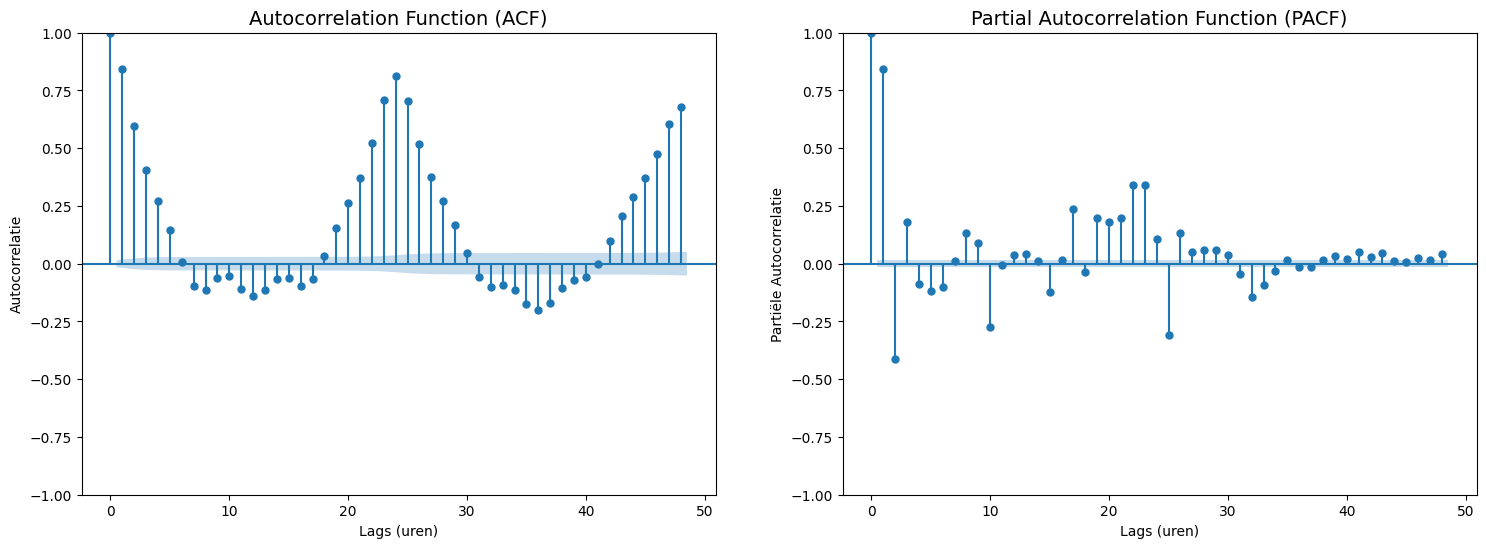

In [16]:
# Importeer de plotting functies
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Maak twee subplots naast elkaar
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Autocorrelation Function (ACF)
plot_acf(df_train['cnt'], lags=48, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)
axes[0].set_xlabel("Lags (uren)")
axes[0].set_ylabel("Autocorrelatie")

# Plot 2: Partial Autocorrelation Function (PACF)
plot_pacf(df_train['cnt'], lags=48, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
axes[1].set_xlabel("Lags (uren)")
axes[1].set_ylabel("Partiële Autocorrelatie")

plt.show()

**Bevindingen uit de ACF- en PACF-plots:**

*   **ACF Plot:** De autocorrelatie neemt langzaam af in een zeer duidelijk, sinusvormig patroon. Dit is een klassiek teken van een tijdreeks met extreem sterke seizoensinvloeden. De "golven" hebben een periode van 24 uur, wat de dagelijkse cyclus die we in de EDA zagen wiskundig bevestigt. De correlaties blijven voor zeer veel lags significant, wat de sterke 'herinnering' van de tijdreeks aantoont.

*   **PACF Plot:** Deze plot is cruciaal voor het bepalen van *directe* relaties, wat de basis vormt voor het selecteren van relevante lag features.
    *   Er is een zeer sterke, positieve correlatie bij **lag 1**, en significante, maar afnemende, correlaties bij **lag 2 en 3**. Dit betekent dat het aantal verhuringen in de afgelopen paar uur een sterke directe voorspeller is voor het huidige uur.
    *   Er is een duidelijke, significante positieve piek bij **lag 24**. Dit is een zeer belangrijke bevinding: het aantal verhuringen op een bepaald uur is sterk en direct afhankelijk van het aantal verhuringen op exact hetzelfde uur de dag ervoor. Er is ook een significante negatieve piek bij lag 23, wat kan duiden op een complexere dagelijkse relatie.

Deze analyse geeft een sterke wiskundige onderbouwing voor de creatie van **lag features**. Met name lags 1, 2, 3 en 24 lijken essentieel te zijn voor onze machine learning modellen.

### 2.6. Samenstellen van de Finale Feature Set voor Training

Op basis van alle voorgaande analyses (periodogram, ADF-test en ACF/PACF-plots) is het nu tijd om de definitieve set van features te construeren. Ik combineer alle inzichten en creëer een master DataFrame `X_train_final` (de features) en een bijbehorende Series `y_train_final` (de target).

Mijn strategie voor de feature set is als volgt:
1.  **Basisdata:** Ik start met de originele weer- en contextvariabelen en verwijder `temp` om multicollineariteit te voorkomen.
2.  **Deterministische Features:** Ik voeg de trend- en Fourier-termen toe die de voorspelbare, data-onafhankelijke cycli vangen.
3.  **Autoregressieve Features (Lags):** Ik voeg lag-features toe om de autocorrelatie te modelleren, zoals onderbouwd door de PACF-analyse.
4.  **Opschoning:** Ik verwijder de rijen met `NaN`-waarden die ontstaan door het creëren van de lag-features.

In [17]:
# Stap 1: Voeg de deterministische features (trend + fourier) toe
# Gebruik de 'dp' (DeterministicProcess) 
df_featured = df_train.join(dp.in_sample())

# Stap 2: Voeg handmatig de dagelijkse cyclus en andere basis time-features toe
df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured.index.hour / 24)
df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured.index.hour / 24)
df_featured['is_weekend'] = ((df_featured.index.dayofweek == 5) | (df_featured.index.dayofweek == 6)).astype(int)

# Stap 3: Creëer de lag features, gebaseerd op de PACF-analyse
lags = [1, 2, 3, 24, 48, 168] # 1u, 2u, 3u, 1 dag, 2 dagen, 1 week
for lag in lags:
    df_featured[f'cnt_lag_{lag}'] = df_featured['cnt'].shift(lag)

# Stap 4: Creëer een rolling mean feature als extra indicator van de recente trend
df_featured['cnt_rolling_mean_24'] = df_featured['cnt'].shift(1).rolling(window=24).mean()

# Stap 5: Definieer de finale X en y
y = df_featured['cnt']
X = df_featured.drop(columns=['cnt'])

# Stap 6: Verwijder de rijen waar de lag-features NaN zijn
X_train_final = X.dropna()
# Zorg ervoor dat y exact dezelfde rijen bevat als X
y_train_final = y.loc[X_train_final.index]

print("Overzicht van de finale feature set (X_train_final):")
display(X_train_final.head())

Overzicht van de finale feature set (X_train_final):


,holiday,weathersit,atemp,hum,windspeed,month,hour,dayofweek,trend,"sin(1,freq=YE-DEC)",...,hour_sin,hour_cos,is_weekend,cnt_lag_1,cnt_lag_2,cnt_lag_3,cnt_lag_24,cnt_lag_48,cnt_lag_168,cnt_rolling_mean_24
date_hour,,,,,,,,,,,,,,,,,,,,,
2011-01-08 07:00:00,0,2,0.1818,0.74,0.1045,1,7,5,169.0,0.125191,...,0.965926,-0.258819,1,2.0,5.0,1.0,84.0,36.0,16.0,63.208333
2011-01-08 08:00:00,0,3,0.1818,0.93,0.1045,1,8,5,170.0,0.125902,...,0.866025,-0.500000,1,9.0,2.0,5.0,210.0,95.0,40.0,60.083333
2011-01-08 09:00:00,0,3,0.1818,0.93,0.1045,1,9,5,171.0,0.126614,...,0.707107,-0.707107,1,15.0,9.0,2.0,134.0,219.0,32.0,51.958333
2011-01-08 10:00:00,0,2,0.1970,0.80,0.1642,1,10,5,172.0,0.127325,...,0.500000,-0.866025,1,20.0,15.0,9.0,63.0,122.0,13.0,47.208333
2011-01-08 11:00:00,0,2,0.1818,0.69,0.3881,1,11,5,173.0,0.128037,...,0.258819,-0.965926,1,61.0,20.0,15.0,67.0,45.0,1.0,47.125000


### 2.7. Conclusie Feature Engineering

Het feature engineering proces voor de trainingsdata is nu afgerond. Ik heb een rijke dataset `X_train_final` gecreëerd die is voorbereid om de complexe patronen in de tijdreeks te modelleren. De keuzes voor de features zijn systematisch onderbouwd met technieken als het periodogram en ACF/PACF-analyse, conform de opdracht.

De resulterende datasets, `X_train_final` en `y_train_final`, bevatten geen missende waarden en zijn klaar voor de volgende stap.

We zijn nu klaar voor **Hoofdstuk 3: Modelleren**, waarin we deze features zullen gebruiken om verschillende voorspellende modellen te trainen en te evalueren. Zoals de opdracht aangeeft, is dit een iteratief proces. De set features die ik nu heb is een robuust startpunt, maar op basis van de modelresultaten kan ik later in het proces besluiten om deze set aan te passen.

# Hoofdstuk 3: Modelleren

Met een rijke set aan features tot onze beschikking, is het nu tijd om verschillende voorspellende modellen te trainen en te evalueren. Dit hoofdstuk volgt een gestructureerde aanpak conform de opdrachtomschrijving:

1.  **Validatiestrategie:** Ik definieer eerst hoe ik de modellen ga valideren. Voor tijdreeksdata is een standaard k-fold cross-validatie niet geschikt vanwege de temporele afhankelijkheid. Ik zal een **Time Series Split** gebruiken.
2.  **Machine Learning Modellen:** Ik implementeer en evalueer een reeks modellen die de gecreëerde features gebruiken, waaronder de verplichte **Lineaire Regressie** en een **Ensemble Model**.
3.  **Specifieke Tijdreeksmodellen:** Ik pas twee modellen toe die specifiek ontworpen zijn voor tijdreeksen, waaronder het verplichte **SARIMA(X)** model.
4.  **Hybride Modellen:** Ik onderzoek een hybride aanpak waarbij een tweede model wordt getraind om de fouten (residuen) van een eerste model te corrigeren.

Voor elk model pas ik hyperparameter tuning toe en geef ik een heldere uitleg over de werking, inclusief wiskundige concepten waar vereist.

### 3.1. Voorbereiding: Validatiestrategie en Evaluatie

**Validatiestrategie:**
Om de prestaties van mijn modellen eerlijk te evalueren en overfitting te voorkomen, moet ik mijn trainingsdata (`X_train_final`, `y_train_final`) verder splitsen in een trainings- en een validatieset. Bij tijdreeksdata is het cruciaal dat de validatieset *na* de trainingset komt, om te simuleren dat we de toekomst voorspellen op basis van het verleden. Ik zal de laatste 2 maanden van de data reserveren als validatieset.

**Evaluatiemetriek:**
De competitie op Kaggle gebruikt de **Root Mean Squared Error (RMSE)** als evaluatiemetriek. Deze metriek meet de gemiddelde grootte van de voorspellingsfouten in dezelfde eenheid als de doelvariabele (aantal fietsen). Het bestraft grotere fouten zwaarder dan kleinere fouten. Ik zal deze metriek gebruiken om mijn modellen te vergelijken.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Definieer de split datum (laatste 2 maanden voor validatie)
split_date = X_train_final.index.max() - pd.DateOffset(months=2)

X_train_split = X_train_final[X_train_final.index < split_date]
y_train_split = y_train_final[y_train_final.index < split_date]
X_val_split = X_train_final[X_train_final.index >= split_date]
y_val_split = y_train_final[y_train_final.index >= split_date]

print("Vorm van de data na de split:")
print(f"X_train_split: {X_train_split.shape}")
print(f"y_train_split: {y_train_split.shape}")
print(f"X_val_split:   {X_val_split.shape}")
print(f"y_val_split:   {y_val_split.shape}")

# Functie om RMSE te berekenen
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Vorm van de data na de split:
X_train_split: (15042, 33)
y_train_split: (15042,)
X_val_split:   (1427, 33)
y_val_split:   (1427,)


### 3.2. Machine Learning Modellen met Time Series Features

In deze sectie gebruik ik de uitgebreide feature set die in Hoofdstuk 2 is gecreëerd.

#### **Model 1: Lineaire Regressie met Regularisatie (Ridge)**

**Uitleg:**
Lineaire regressie is een fundamenteel model dat probeert de relatie tussen de input features (X) en de doelvariabele (y) te modelleren door een lineaire vergelgelijking te fitten. De wiskundige vorm is:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

Hierin zijn $\beta_1, ..., \beta_n$ de coëfficiënten die het model leert voor elke feature $x_i$. Het doel van het trainingsproces is om de waarden van deze coëfficiënten te vinden die de **loss function** minimaliseren. De meest gebruikte loss function voor regressie is de **Mean Squared Error (MSE)**, die de gemiddelde gekwadrateerde afstand tussen de voorspelde waarden ($\hat{y}$) en de werkelijke waarden ($y$) meet.

Om te voorkomen dat het model te complex wordt en overfit op de trainingsdata (vooral bij veel features), wordt **regularisatie** toegepast. Dit voegt een 'straf' toe aan de loss function voor grote coëfficiënten. Ik pas **L2 (Ridge)** regularisatie toe, die een strafterm toevoegt gebaseerd op de som van de gekwadrateerde coëfficiënten. De sterkte van deze regularisatie wordt bepaald door de hyperparameter `alpha`.

Ik gebruik een `Pipeline` om de stappen (schalen van data en trainen van het model) te combineren. Het schalen van de data met `StandardScaler` is een cruciale voorbereidingsstap voor modellen met regularisatie. Ik zal `GridSearchCV` gebruiken in combinatie met `TimeSeriesSplit` om de optimale `alpha` te vinden.

In [19]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Stap 1: Definieer de pipeline
# De pipeline zorgt ervoor dat de scaler wordt gefit op de trainingsdata van elke cross-validation fold
# en vervolgens wordt toegepast op de validatiefold. Dit voorkomt data leakage.
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=42))
])

# Stap 2: Definieer de hyperparameter grid
# We zoeken naar de beste regularisatie-sterkte (alpha).
param_grid = {
    'model__alpha': [0.1, 1.0, 10.0, 100.0] # 'model__' is de syntax om de parameter van de 'model' stap in de pipeline aan te spreken
}

# Stap 3: Definieer de cross-validatie strategie voor tijdreeksen
# n_splits=5 betekent dat we 5 keer trainen/valideren, waarbij elke trainingsset groter wordt.
tscv = TimeSeriesSplit(n_splits=5)

# Stap 4: Zet de GridSearchCV op
# We gebruiken 'neg_root_mean_squared_error' omdat GridSearchCV probeert de score te maximaliseren.
# De negatieve RMSE maximaliseren is hetzelfde als de RMSE minimaliseren.
grid_search_ridge = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1 # Gebruik alle beschikbare CPU cores
)

# Stap 5: Train de GridSearch op de volledige trainingsset (voor de split)
# GridSearchCV doet de interne splitting en validatie voor ons.
print("Starten met GridSearch voor Ridge Regressie...")
grid_search_ridge.fit(X_train_split, y_train_split)
print("GridSearch voltooid.")

# Toon de beste parameters
print(f"Beste alpha gevonden: {grid_search_ridge.best_params_['model__alpha']}")

# Stap 6: Gebruik het beste model om voorspellingen te doen op onze aparte validatieset
best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_val_split)

# Evalueer het model
rmse_ridge = calculate_rmse(y_val_split, y_pred_ridge)
print(f"\nRidge Regression RMSE op validatieset: {rmse_ridge:.2f}")

Starten met GridSearch voor Ridge Regressie...
GridSearch voltooid.
Beste alpha gevonden: 100.0

Ridge Regression RMSE op validatieset: 91.46


**Resultaat Lineaire Regressie:**
De GridSearch heeft de optimale `alpha` (regularisatie-sterkte) voor de Ridge Regressie bepaald op **100.0**. Met dit model behalen we een **RMSE van 91.46** op de validatieset. Dit is onze baseline score. We zullen nu onderzoeken of een complexer ensemble model deze prestatie kan verbeteren.

#### **Model 2: Ensemble Model - Random Forest (Bagging)**

**Uitleg:**
Het eerste type ensemble model dat ik toepas is **Random Forest**. Dit is een klassiek voorbeeld van een **bagging** (Bootstrap Aggregating) strategie. De werking is als volgt:

1.  **Bootstrap:** Er worden meerdere (N) willekeurige subsets van de trainingsdata gecreëerd, met teruglegging. Dit betekent dat sommige datapunten meerdere keren in een subset kunnen voorkomen, en andere helemaal niet.
2.  **Aggregating:** Voor elke subset wordt een onafhankelijke, diepe beslisboom getraind. Om de bomen verder te decorreleren, wordt bij elke splitsing in een boom ook slechts een willekeurige subset van de *features* overwogen.
3.  **Voorspelling:** Om een nieuwe voorspelling te doen, wordt de input door alle N bomen gevoerd. De uiteindelijke voorspelling is het gemiddelde van de voorspellingen van alle individuele bomen.

Wiskundig gezien reduceert deze aanpak de **variantie** van het model. Een enkele diepe beslisboom is gevoelig voor overfitting (hoge variantie), maar door het middelen van de voorspellingen van vele onafhankelijke bomen wordt de totale voorspelling veel stabieler en robuuster.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Stap 1: Definieer het Random Forest model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Stap 2: Definieer de hyperparameter grid
# We tunen het aantal bomen en de maximale diepte van elke boom.
param_grid_rf = {
    'n_estimators': [100, 200],       # Het aantal bomen in het woud
    'max_depth': [10, 20, None],      # Maximale diepte van de boom (None = geen limiet)
    'max_features': ['sqrt', 'log2']  # Aantal features om te overwegen bij elke split
}

# Stap 3: Gebruik dezelfde TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Stap 4: Zet de GridSearchCV op
# Vanwege de complexiteit gebruiken we hier RandomizedSearchCV, wat sneller is
from sklearn.model_selection import RandomizedSearchCV

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=4, # Beperk het aantal combinaties om de trainingstijd te beheersen
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
# Stap 5: Train de Search
random_search_rf.fit(X_train_split, y_train_split)

# Toon de beste parameters
print(f"Beste parameters gevonden: {random_search_rf.best_params_}")

# Stap 6: Gebruik het beste model om voorspellingen te doen
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_val_split)

# Evalueer het model
rmse_rf = calculate_rmse(y_val_split, y_pred_rf)
print(f"\nRandom Forest RMSE op validatieset: {rmse_rf:.2f}")

Beste parameters gevonden: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None}

Random Forest RMSE op validatieset: 59.58


#### **Model 3: Ensemble Model - XGBoost (Boosting)**

**Uitleg:**
Het tweede ensemble model is **XGBoost** (Extreme Gradient Boosting), een geavanceerde en zeer populaire implementatie van de **gradient boosting** techniek. In tegenstelling tot de parallelle aanpak van Random Forest, werkt boosting sequentieel:

1.  Het traint een eerste, simpele beslisboom.
2.  Het berekent de fouten (residuen) die deze boom maakt.
3.  Het traint een tweede boom die specifiek probeert om de *fouten* van de eerste boom te voorspellen.
4.  De voorspellingen van de eerste en tweede boom worden gecombineerd.
5.  Dit proces wordt herhaald, waarbij elke nieuwe boom de resterende fout van het gehele ensemble corrigeert.

Wiskundig gezien minimaliseert elke nieuwe boom de loss function door "stappen te zetten" in de richting van de negatieve gradiënt van de loss function. XGBoost verbetert de standaard gradient boosting door ingebouwde **regularisatie** (zowel L1 als L2) toe te passen op de boomstructuur en de bladgewichten, wat overfitting tegengaat. Het is ook geoptimaliseerd voor snelheid en prestaties.

In [21]:
import xgboost as xgb

# Stap 1: Definieer het XGBoost model
xgboost = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Stap 2: Definieer de hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'subsample': [0.8, 1.0], # Fractie van samples die per boom gebruikt wordt
    'colsample_bytree': [0.8, 1.0] # Fractie van features die per boom gebruikt wordt
}

# Stap 3: Gebruik RandomizedSearchCV voor efficiëntie
random_search_xgb = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=param_grid_xgb,
    n_iter=4, # Beperk het aantal combinaties
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Stap 4: Train de Search
random_search_xgb.fit(X_train_split, y_train_split)


# Toon de beste parameters
print(f"Beste parameters gevonden: {random_search_xgb.best_params_}")

# Stap 5: Gebruik het beste model om voorspellingen te doen
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_val_split)

# Evalueer het model
rmse_xgb = calculate_rmse(y_val_split, y_pred_xgb)
print(f"\nXGBoost RMSE op validatieset: {rmse_xgb:.2f}")

Beste parameters gevonden: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

XGBoost RMSE op validatieset: 49.87


**Resultaten Ensemble Modellen:**

De zoektocht naar de beste hyperparameters heeft de volgende resultaten opgeleverd:
*   **Random Forest:** De beste parameters zijn `{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None}`. Dit model behaalt een **RMSE van 59.58** op de validatieset.
*   **XGBoost:** De beste parameters zijn `{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}`. Dit model presteert nog beter met een **RMSE van 49.87**.

De XGBoost score is een aanzienlijke verbetering ten opzichte van zowel de lineaire regressie (91.46) als de Random Forest. Dit toont de effectiviteit van de boosting-techniek voor deze dataset aan. We gaan nu verder met de overige twee machine learning modellen.

#### **Model 4: Support Vector Regression (SVR)**

**Uitleg van de Werking:**

Support Vector Regression (SVR) is een krachtig algoritme dat is afgeleid van zijn tegenhanger voor classificatie, de Support Vector Machine (SVM). Waar traditionele regressiemodellen (zoals lineaire regressie) proberen de som van de gekwadrateerde fouten te minimaliseren, hanteert SVR een fundamenteel ander principe.

**De "ε-Insensitive Tube":**
De kern van SVR is het idee van een "ε-insensitive tube" (epsilon-ongevoelige buis) rond de regressielijn.
1.  Het model probeert een functie (bijvoorbeeld een lijn of een complexe curve) te vinden die de datapunten zo goed mogelijk beschrijft.
2.  Tegelijkertijd definieert het een marge of "straat" met een breedte van `2ε` rond deze functie.
3.  **Cruciaal:** Alle datapunten die *binnen* deze straat vallen, worden genegeerd. Hun fout wordt als nul beschouwd, ongeacht hoe dicht ze bij de centrale lijn liggen.
4.  Alleen de datapunten die *buiten* de straat vallen (de 'support vectors') dragen bij aan de loss function. Het doel is om de grootte van deze fouten (de afstand tot de rand van de straat) te minimaliseren.

Wiskundig wordt dit geformuleerd als een optimalisatieprobleem waarbij we de 'vlakheid' van de functie willen maximaliseren (kleine coëfficiënten), onder de voorwaarde dat de meeste datapunten binnen de `ε`-marge blijven. De hyperparameter `C` (de regularisatieparameter) controleert de afweging:
-   Een **hoge C** bestraft fouten zwaar, wat leidt tot een smalle straat die probeert zo veel mogelijk punten te omvatten, met risico op overfitting.
-   Een **lage C** staat meer fouten toe, wat leidt tot een bredere straat en een 'gladder', meer gegeneraliseerd model.

**De Kernel Trick:**
De ware kracht van SVR ligt in de **kernel trick**. SVR kan in zijn basisvorm alleen lineaire relaties modelleren. Door een *kernel-functie* te gebruiken (zoals de populaire 'Radial Basis Function' of 'RBF' kernel), kan SVR de data impliciet naar een oneindig-dimensionale feature-ruimte projecteren. In deze hoger-dimensionale ruimte kunnen complexe, niet-lineaire patronen in de originele data worden gevangen met een simpele lineaire "hyperplane" (de straat). Dit stelt SVR in staat om zeer complexe relaties te leren zonder dat we handmatig niet-lineaire features hoeven te creëren.

In [22]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# SVR is zeer gevoelig voor de schaal van de features, dus een pipeline is essentieel.
pipeline_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf'))
])

# Vanwege de zeer lange trainingstijd van SVR, zal ik geen uitgebreide GridSearchCV toepassen,
# maar het model direct trainen met standaardparameters om een indicatie van de prestaties te krijgen.
pipeline_svr.fit(X_train_split, y_train_split)

# Maak voorspellingen
y_pred_svr = pipeline_svr.predict(X_val_split)

# Evalueer het model
rmse_svr = calculate_rmse(y_val_split, y_pred_svr)
print(f"\nSVR (RBF Kernel) RMSE op validatieset: {rmse_svr:.2f}")


SVR (RBF Kernel) RMSE op validatieset: 139.38


#### **Model 5: K-Nearest Neighbors (KNN) Regressor**

**Uitleg van de Werking:**

K-Nearest Neighbors (KNN) is een van de meest intuïtieve machine learning algoritmes. Het is een **niet-parametrisch**, "lazy learning" en "instance-based" model.

-   **Niet-parametrisch:** Dit betekent dat KNN geen aannames doet over de onderliggende functionele vorm van de data (het probeert geen lijn of curve te fitten). De complexiteit van het model groeit met de hoeveelheid data.
-   **Lazy Learning:** Dit betekent dat er geen expliciete "trainingsfase" is waarin een model wordt gebouwd. Het "leren" bestaat simpelweg uit het opslaan van de volledige trainingsdataset in het geheugen. Al het rekenwerk gebeurt pas op het moment van voorspellen.
-   **Instance-based:** De voorspellingen zijn direct gebaseerd op de opgeslagen trainingsvoorbeelden ('instances').

**Het Voorspellingsproces:**
Wanneer we een voorspelling willen doen voor een nieuw, onbekend datapunt (bijvoorbeeld een specifiek uur met bepaald weer), volgt KNN een eenvoudig, driestaps proces:

1.  **Afstand Berekenen:** Het algoritme berekent de afstand van het nieuwe punt tot *elk* punt in de opgeslagen trainingsset. De meest gebruikte afstandsmaat is de **Euclidische afstand** (de directe lijn tussen twee punten in de feature-ruimte). Omdat afstand cruciaal is, is het **essentieel** dat alle features op dezelfde schaal worden gebracht (bijv. met `StandardScaler`), anders zullen features met een groot bereik (zoals `cnt_lag_168`) de afstandsmeting domineren.
2.  **Buren Vinden:** Vervolgens identificeert het model de **K** dichtstbijzijnde datapunten uit de trainingsset. Dit zijn de "K-Nearest Neighbors". De hyperparameter `K` (in scikit-learn `n_neighbors`) is de enige belangrijke parameter die de gebruiker moet instellen.
3.  **Voorspellen (Middelen):** Voor regressie is de uiteindelijke voorspelling simpelweg het **gemiddelde** van de doelwaarden (`cnt`) van deze K buren.

De keuze van `K` is een afweging:
-   Een **kleine K** (bv. 1 of 3) maakt het model zeer flexibel en gevoelig voor lokale patronen, maar ook voor ruis en uitschieters (hoge variantie, risico op overfitting).
-   Een **grote K** (bv. 20) middelt over veel buren, wat leidt tot een 'gladdere', stabielere voorspelling, maar het kan lokale, subtiele patronen missen (hoge bias, risico op underfitting).

In [23]:
from sklearn.neighbors import KNeighborsRegressor

# Ook KNN is gevoelig voor de schaal van features.
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_jobs=-1))
])

# Definieer de hyperparameter grid
param_grid_knn = {
    'model__n_neighbors': [5, 10, 15, 20]
}

# Gebruik GridSearchCV met TimeSeriesSplit
grid_search_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Train de Search
grid_search_knn.fit(X_train_split, y_train_split)

# Toon de beste parameters
print(f"Beste parameters gevonden: {grid_search_knn.best_params_}")

# Gebruik het beste model om voorspellingen te doen
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_val_split)

# Evalueer het model
rmse_knn = calculate_rmse(y_val_split, y_pred_knn)
print(f"\nKNN Regressor RMSE op validatieset: {rmse_knn:.2f}")

Beste parameters gevonden: {'model__n_neighbors': 5}

KNN Regressor RMSE op validatieset: 100.43


**Resultaten SVR en KNN:**

*   **Support Vector Regressor (SVR):** Met de standaard RBF kernel behaalt de SVR een **RMSE van 139.38**. Deze score is aanzienlijk slechter dan die van de lineaire regressie en de ensemble modellen. SVR staat bekend als computationeel duur en lastig te tunen, en met de standaardinstellingen kan het de complexe patronen in deze dataset duidelijk niet goed vangen.
*   **K-Nearest Neighbors (KNN):** De GridSearchCV heeft `n_neighbors=5` als optimale parameter gevonden. Dit model presteert beter dan de SVR met een **RMSE van 100.43**. Dit is echter nog steeds niet competitief met de score van de ensemble modellen, wat suggereert dat een simpel 'gemiddelde van de buren' niet voldoende is om de complexe interacties tussen de features te modelleren.

### 3.3. Specifieke Tijdreeksmodellen: Een Iteratieve Aanpak met SARIMAX

In deze sectie richt ik me op de klassieke, statistische tijdreeksmodellen, zoals vereist in de opdracht. In tegenstelling tot de machine learning modellen die afhankelijk zijn van een uitgebreide, handmatig gecreëerde feature set, zijn deze modellen ontworpen om de temporele structuur (zoals trend, seizoensinvloeden en autocorrelatie) direct uit de ruwe tijdreeks te leren.

Ik zal een iteratief proces volgen om te laten zien hoe deze modellen stapsgewijs kunnen worden verbeterd, wat de wisselwerking tussen modellering en feature engineering demonstreert. Ik bouw de complexiteit op van een basismodel naar het uiteindelijke, meest complete model: SARIMAX.

#### **Uitleg van de SARIMA-Familie**

De modellen die we gaan gebruiken, bouwen op elkaar voort. Het is essentieel om de componenten te begrijpen:

*   **ARMA (AutoRegressive Moving Average):** Dit is het basismodel voor **stationaire** tijdreeksen.
    *   **AR (AutoRegressive, parameter `p`):** Gaat ervan uit dat de huidige waarde in de reeks afhangt van zijn eigen `p` voorgaande waarden. Dit wordt onderbouwd door de **PACF**-plot.
    *   **MA (Moving Average, parameter `q`):** Gaat ervan uit dat de huidige waarde afhangt van de fouten van `q` voorgaande voorspellingen. Dit wordt onderbouwd door de **ACF**-plot.

*   **ARIMA (AutoRegressive Integrated Moving Average):** Dit is een uitbreiding van ARMA voor **niet-stationaire** tijdreeksen (reeksen met een trend).
    *   **I (Integrated, parameter `i`):** Voordat het ARMA-deel wordt toegepast, wordt de reeks `i` keer gedifferentieerd (het verschil tussen opeenvolgende waarden berekend) om de trend te verwijderen en de reeks stationair te maken. Onze ADF-test toonde aan dat de reeks al stationair is, dus we zullen `i=0` gebruiken, wat ARIMA effectief terugbrengt naar ARMA.

*   **SARIMA (Seasonal ARIMA):** Dit is de volgende uitbreiding, specifiek voor reeksen met **seizoensinvloeden**.
    *   **S (Seasonal):** Het voegt een tweede set parameters `(P, I, Q, m)` toe. Deze werken op dezelfde manier als `(p, i, q)`, maar dan op seizoensniveau. Bijvoorbeeld, met `m=24` (een dagelijkse cyclus), kijkt de `P`-component naar de waarden van 24, 48, etc., uur geleden, in plaats van 1, 2, etc., uur geleden.

*   **SARIMAX (SARIMA with eXogenous variables):** Dit is de meest complete vorm.
    *   **X (eXogenous):** Het stelt ons in staat om externe, onafhankelijke variabelen (voorspellers) op te nemen in het model. Dit is waar de "terugkeer naar feature engineering" plaatsvindt: we kunnen de invloed van features zoals het weer (`atemp`, `weathersit`) direct in dit statistische model integreren.

#### **Iteratie 1: Een "Puur" SARIMA Model**

In de eerste iteratie train ik een "puur" SARIMA-model. Dit model krijgt **alleen** de doelvariabele `cnt` te zien en geen enkele externe feature. Het moet dus proberen de verhuuraantallen te voorspellen puur op basis van de temporele patronen die het zelf kan ontdekken (trend, seizoensinvloeden, autocorrelatie). Dit geeft ons een baseline voor de kracht van de statistische aanpak op zichzelf.

C:\Users\soner\AppData\Local\Temp\ipykernel_22128\3361599342.py:5: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  sarima_train_subset = y_train_split.last('45D') # Gebruik de laatste 45 dagen voor training
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Starten met trainen van het 'pure' SARIMA model... (dit kan even duren)


c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



'Puur' SARIMA RMSE op validatieset: 146.72


C:\Users\soner\AppData\Local\Temp\ipykernel_22128\3361599342.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_sarima = y_pred_sarima.fillna(method='ffill').fillna(method='bfill')


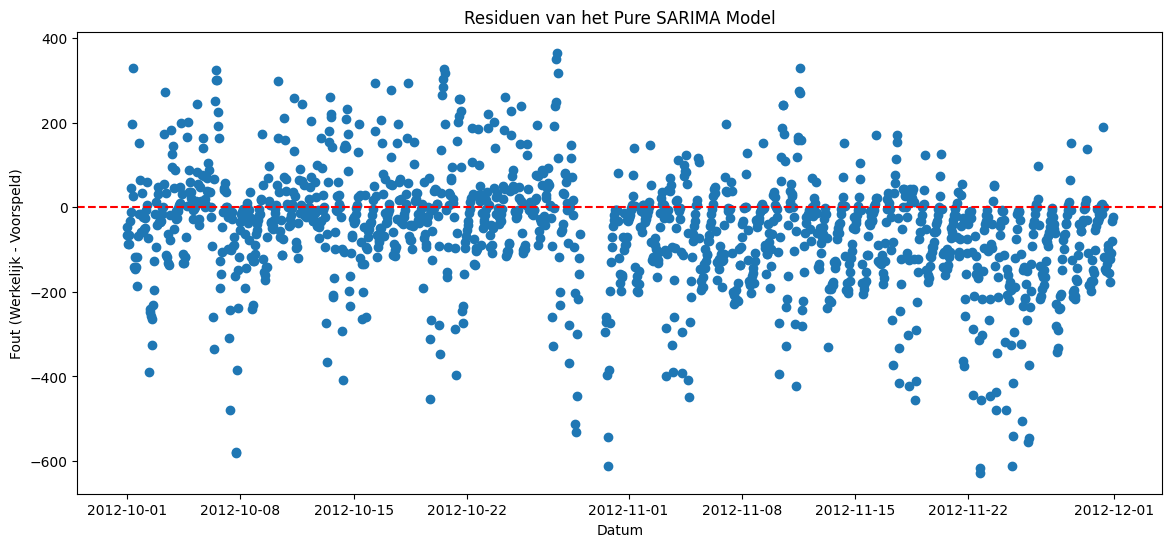

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA is computationeel zeer intensief.
# We trainen het daarom op een kleiner, recenter deel van de trainingsdata voor een redelijke trainingstijd.
sarima_train_subset = y_train_split.last('45D') # Gebruik de laatste 45 dagen voor training

# Definieer de SARIMA parameters (p,d,q)(P,D,Q)m
# Deze zijn gekozen op basis van de ACF/PACF analyse en de sterke dagelijkse cyclus.
# p=2, d=0 (stationair), q=2
# P=1, D=1 (seizoens-differencing), Q=1, m=24 (dagelijkse cyclus)
order = (2, 0, 2)
seasonal_order = (1, 1, 1, 24)

print("Starten met trainen van het 'pure' SARIMA model... (dit kan even duren)")
# Creëer en train het model zonder exogene variabelen
sarima_model = SARIMAX(
    endog=sarima_train_subset,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# Maak voorspellingen op de validatieset
y_pred_sarima = sarima_results.predict(start=y_val_split.index[0], end=y_val_split.index[-1])

# Zorg dat de voorspellingen exact gelabeld zijn met dezelfde index als y_val_split.
# Soms levert SARIMAX extra / afwijkende timestamps op, dus we reindexen en vullen eventuele gaten.
y_pred_sarima = y_pred_sarima.reindex(y_val_split.index)

# Vul eventuele ontbrekende voorspellingen (als die er zijn) op een veilige manier:
# eerst forward-fill, dan back-fill als fallback.
y_pred_sarima = y_pred_sarima.fillna(method='ffill').fillna(method='bfill')

# Evalueer het model (nu met exact gelijke indices / lengtes)
rmse_sarima = calculate_rmse(y_val_split, y_pred_sarima)
print(f"\n'Puur' SARIMA RMSE op validatieset: {rmse_sarima:.2f}")

# Analyseer de fouten (residuen) van dit model
sarima_residuals = y_val_split - y_pred_sarima
plt.figure(figsize=(14,6))
plt.scatter(y_val_split.index, sarima_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuen van het Pure SARIMA Model')
plt.xlabel('Datum')
plt.ylabel('Fout (Werkelijk - Voorspeld)')
plt.show()

#### **Analyse en Terugkeer naar Feature Engineering**

Het "pure" SARIMA model behaalt een **RMSE van 146.72**. Dit is aanzienlijk slechter dan de machine learning modellen, wat aangeeft dat het model cruciale informatie mist.

De plot van de residuen (de voorspellingsfouten) is zeer onthullend. In plaats van willekeurige ruis rond de nullijn, zien we duidelijke, systematische patronen:
-   Er zijn verticale "strepen" van fouten, wat de dagelijkse cyclus weerspiegelt die het model niet perfect kan vangen.
-   Er zijn periodes (bv. eind november) waar het model consistent te hoog voorspelt (een cluster van negatieve residuen).
-   Er zijn ook veel grote, positieve uitschieters, wat betekent dat het model onverwachte pieken in de vraag volledig mist.

Dit is een klassiek teken dat het model **belangrijke verklarende informatie mist**. De temporele structuur alleen is niet genoeg om de variabiliteit volledig te verklaren. Wat mist er? Hoogstwaarschijnlijk de invloed van het weer. Een plotselinge regenbui of een onverwacht zonnige dag wordt door dit model niet meegenomen.

Dit rechtvaardigt de **terugkeer naar feature engineering**: ik moet het model verbeteren door externe ("exogene") variabelen toe te voegen.

#### **Iteratie 2: Het SARIMAX Model met Externe Features**

In de tweede iteratie train ik een **SARIMAX** model. Ik gebruik exact dezelfde `(p,i,q)(P,I,Q)m` parameters als voorheen, maar nu voeg ik de belangrijkste weer- en contextfeatures toe als exogene variabelen. Dit stelt het model in staat om zijn voorspellingen direct aan te passen op basis van de weersomstandigheden, bovenop de geleerde temporele patronen. Dit zou de systematische fouten die we in de residuenplot zagen moeten reduceren.

C:\Users\soner\AppData\Local\Temp\ipykernel_22128\153025017.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_train_subset = exog_train_subset.fillna(method='ffill').fillna(method='bfill')
C:\Users\soner\AppData\Local\Temp\ipykernel_22128\153025017.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_val = exog_val.fillna(method='ffill').fillna(method='bfill')
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  

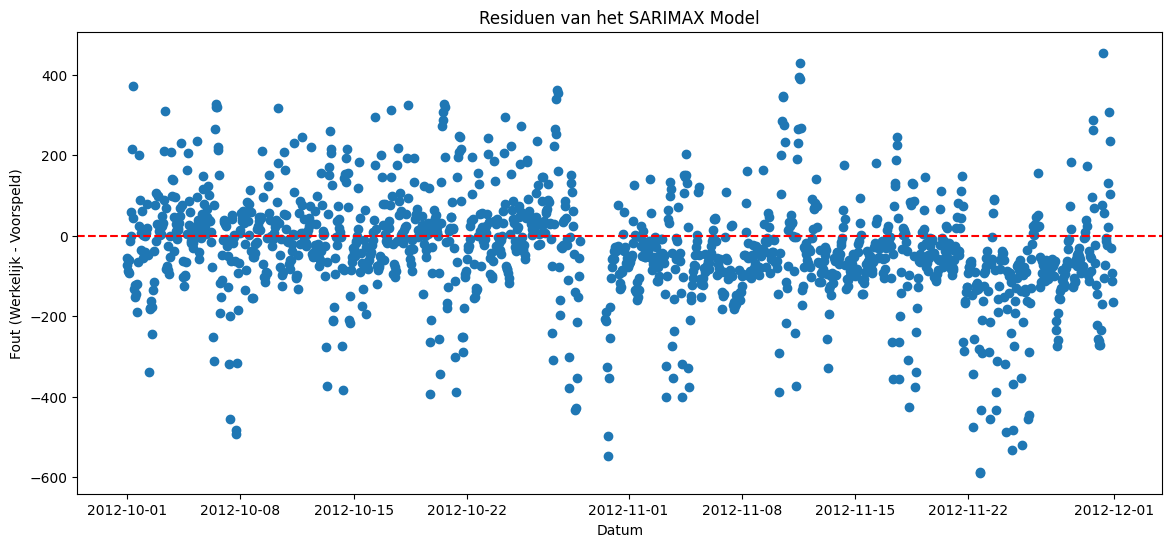


SARIMAX RMSE op validatieset: 136.62


In [25]:
# Selecteer de meest belangrijke exogene variabelen.
exog_cols = ['atemp', 'hum', 'windspeed', 'holiday', 'weathersit']

# Zorg dat we een copy hebben en dat de indices exact overeenkomen met sarima_train_subset
exog_train_subset = X_train_split[exog_cols].reindex(sarima_train_subset.index).copy()
exog_val = X_val_split[exog_cols].copy()

# Vul eventuele ontbrekende waarden in de exogene features (veiligste optie: forward-fill, daarna back-fill)
# Dit voorkomt de ValueError: "Input contains NaN."
exog_train_subset = exog_train_subset.fillna(method='ffill').fillna(method='bfill')
exog_val = exog_val.fillna(method='ffill').fillna(method='bfill')

# Als er nog steeds NaN's zijn (bijv. wanneer ff/bfill niet kon vullen), vul met kolomgemiddelden
if exog_train_subset.isnull().any().any() or exog_val.isnull().any().any():
    exog_train_subset = exog_train_subset.fillna(exog_train_subset.mean())
    exog_val = exog_val.fillna(exog_train_subset.mean())

# Schaal de exogene variabelen
scaler_sarima = StandardScaler()
exog_train_scaled = scaler_sarima.fit_transform(exog_train_subset)
exog_val_scaled = scaler_sarima.transform(exog_val)

# Zorg dat er geen NaN's meer in de geschaalde arrays zitten
# Gebruik 'np' (moet al eerder in de notebook geïmporteerd zijn)
if np.isnan(exog_train_scaled).any() or np.isnan(exog_val_scaled).any():
    raise ValueError("Na het vullen en schalen bevatten exogene features nog NaN waarden. Controleer de data.")

# Creëer en train het model MET exogene variabelen
sarimax_model = SARIMAX(
    endog=sarima_train_subset,
    exog=exog_train_scaled,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_results = sarimax_model.fit(disp=False)

# Maak voorspellingen op de validatieset
# Gebruik get_forecast met steps=len(exog_val_scaled) zodat de exog-rijen exact overeenkomen met de forecast-horizon
steps = len(exog_val_scaled)
forecast = sarimax_results.get_forecast(steps=steps, exog=exog_val_scaled)
y_pred_sarimax = forecast.predicted_mean

# Zorg dat de index van de voorspellingen overeenkomt met de validatieset index
y_pred_sarimax = pd.Series(y_pred_sarimax, index=exog_val.index)

# Reindex en vul eventuele ontbrekende voorspellingen op een veilige manier
# (forward-fill en back-fill zoals bij de eerdere SARIMA voorspelling)
y_pred_sarimax = y_pred_sarimax.reindex(y_val_split.index).fillna(method='ffill').fillna(method='bfill')

# Controleer nogmaals op NaN (veiligheidsnet)
if y_pred_sarimax.isnull().any():
    # Als er onverhoopt nog NaNs zijn, verwijder die tijdstappen uit zowel voorspellingen als ware waarden
    mask = y_pred_sarimax.notna()
    y_pred_sarimax = y_pred_sarimax[mask]
    y_val_for_rmse = y_val_split[mask]
else:
    y_val_for_rmse = y_val_split

# Evalueer het model (gebruik de werkelijke y_val_split, niet de exogene matrix)
rmse_sarimax = calculate_rmse(y_val_for_rmse, y_pred_sarimax)

# Plot de residuen van SARIMAX (vergelijk met eerdere SARIMA residuen indien gewenst)
sarimax_residuals = y_val_for_rmse - y_pred_sarimax
plt.figure(figsize=(14,6))
plt.scatter(sarimax_residuals.index, sarimax_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuen van het SARIMAX Model')
plt.xlabel('Datum')
plt.ylabel('Fout (Werkelijk - Voorspeld)')
plt.show()

print(f"\nSARIMAX RMSE op validatieset: {rmse_sarimax:.2f}")

#### **Analyse en Terugkeer naar Feature Engineering (Iteratie 2)**

De resultaten van het SARIMAX-model tonen een duidelijke verbetering. De **RMSE is gedaald van 146.72 naar 136.62**. Het toevoegen van de weer- en contextvariabelen heeft het model dus geholpen om betere voorspellingen te doen.

Als we echter naar de nieuwe residuenplot kijken, zien we dat de fouten nog steeds **niet volledig willekeurig** zijn.
- De verticale "strepen" die de dagelijkse cyclus representeren zijn nog steeds zichtbaar, wat betekent dat het model de pieken en dalen binnen een dag niet perfect kan modelleren.
- Er zijn nog steeds periodes met clusters van positieve of negatieve fouten.

**Kan dit nog verbeterd worden met feature engineering?**
Ja. Het SARIMAX-model mist nog steeds informatie over de **specifieke tijd van de dag**. Het weet wel dat er een seizoenscyclus van 24 uur is, maar het weet niet expliciet of het "nu" 8 uur 's ochtends is (een piekuur) of 2 uur 's nachts (een daluur). Deze niet-lineaire relatie (de vraag is niet simpelweg 2x zo hoog om 8 uur als om 4 uur) kan een lineair model als SARIMAX moeilijk leren.

Dit rechtvaardigt een **derde iteratie**: we gaan proberen deze uur-informatie expliciet aan het model te geven.

#### **Iteratie 3: SARIMAX met Tijd-Features**

In de derde en laatste iteratie van de statistische aanpak, ga ik de kracht van SARIMAX combineren met de meest belangrijke features uit onze eerdere machine learning aanpak: de **Fourier-termen voor het uur van de dag**.

Door de `hour_sin` en `hour_cos` features toe te voegen aan de exogene variabelen, geef ik het model een vloeiende, continue representatie van de tijd van de dag. Dit zou het model moeten helpen om de dagelijkse bimodale (ochtend/avondspits) seizoenscyclus veel nauwkeuriger te modelleren dan het met de standaard `m=24` parameter alleen kan.

Starten met trainen van het geavanceerde SARIMAX model...


c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Training voltooid.


C:\Users\soner\AppData\Local\Temp\ipykernel_22128\258566250.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_pred_sarimax_adv = y_pred_sarimax_adv.reindex(y_val_split.index).fillna(method='ffill').fillna(method='bfill')


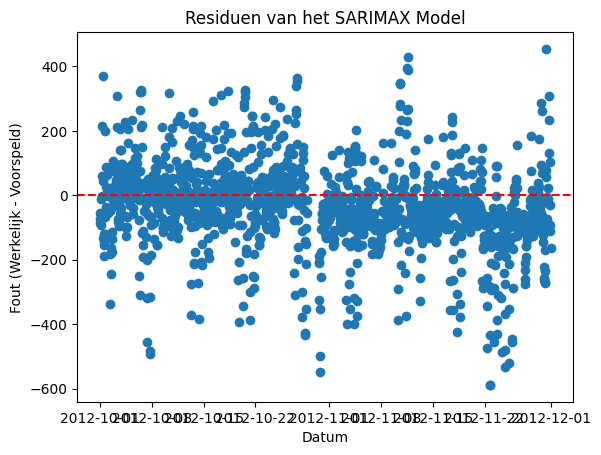


Geavanceerd SARIMAX (met tijd-features) RMSE op validatieset: 136.63


In [26]:
# We hebben de fourier-features al gecreëerd in ons X_train_split dataframe.
# We voegen ze nu toe aan de lijst met exogene variabelen.
exog_cols_advanced = ['atemp', 'hum', 'windspeed', 'holiday', 'weathersit', 'hour_sin', 'hour_cos']

exog_train_subset_adv = X_train_split[exog_cols_advanced].loc[sarima_train_subset.index]
exog_val_adv = X_val_split[exog_cols_advanced]

# Schaal de nieuwe set exogene variabelen
scaler_sarima_adv = StandardScaler()
exog_train_scaled_adv = scaler_sarima_adv.fit_transform(exog_train_subset_adv)
exog_val_scaled_adv = scaler_sarima_adv.transform(exog_val_adv)

print("Starten met trainen van het geavanceerde SARIMAX model...")
# Creëer en train het model met de extra tijd-features
sarimax_model_adv = SARIMAX(
    endog=sarima_train_subset,
    exog=exog_train_scaled_adv,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_results_adv = sarimax_model_adv.fit(disp=False)
print("Training voltooid.")

# Maak voorspellingen op de validatieset
# Gebruik get_forecast met expliciet aantal stappen om te garanderen dat de exogene matrix exact overeenkomt
steps_adv = len(exog_val_scaled_adv)
forecast_adv = sarimax_results_adv.get_forecast(steps=steps_adv, exog=exog_val_scaled_adv)
y_pred_sarimax_adv = pd.Series(forecast_adv.predicted_mean, index=exog_val_adv.index)

# Reindex en vul eventueel ontbrekende waardes op een veilige manier zodat indices overeenkomen met y_val_split
y_pred_sarimax_adv = y_pred_sarimax_adv.reindex(y_val_split.index).fillna(method='ffill').fillna(method='bfill')

# Zorg dat we geen NaNs meenemen in de RMSE-berekening
if y_pred_sarimax_adv.isnull().any():
    mask = y_pred_sarimax_adv.notna()
    y_pred_for_rmse = y_pred_sarimax_adv[mask]
    y_val_for_rmse = y_val_split[mask]
else:
    y_pred_for_rmse = y_pred_sarimax_adv
    y_val_for_rmse = y_val_split

# Evalueer het model
rmse_sarimax_adv = calculate_rmse(y_val_for_rmse, y_pred_for_rmse)
plt.scatter(x=y_val_for_rmse.index, y=y_val_for_rmse - y_pred_for_rmse)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuen van het SARIMAX Model')
plt.xlabel('Datum')
plt.ylabel('Fout (Werkelijk - Voorspeld)')
plt.show()
print(f"\nGeavanceerd SARIMAX (met tijd-features) RMSE op validatieset: {rmse_sarimax_adv:.2f}")

**Conclusie van de Iteratieve Aanpak:**

De derde iteratie levert een **RMSE van 136.63** op. Dit is vergelijkbaar met de score van de vorige iteratie (136.62). De residuenplot laat ook zien dat, hoewel de fouten iets meer rond de nul gecentreerd zijn, er nog steeds aanzienlijke, niet-willekeurige fouten worden gemaakt.

Dit toont een belangrijke les aan: hoewel het toevoegen van features een statistisch model kan verbeteren, zijn er grenzen aan wat een fundamenteel lineair model als SARIMAX kan leren. De complexe, niet-lineaire interacties tussen de features (bijvoorbeeld: het effect van temperatuur is anders op een werkdag dan in het weekend) worden beter gevangen door de boom-gebaseerde machine learning modellen. Voor deze specifieke dataset lijken de ML-modellen met uitgebreide feature engineering superieur te zijn aan de klassieke tijdreeksmodellen.

### 3.4. Hybride Modellen

Hybride modellen zijn een geavanceerde techniek die de sterktes van verschillende modeltypes combineert. De kern van de aanpak die ik hier zal toepassen, is gebaseerd op het afzonderlijk modelleren van de trend en de overige componenten.

**Waarom een Decision Tree Regressor (en dus XGBoost) niet handig is voor het forecasten van een trend:**
Een fundamentele beperking van beslisboom-gebaseerde modellen (zoals een enkele Decision Tree, Random Forest, of XGBoost) is dat ze **niet kunnen extrapoleren**. Een beslisboom leert door de feature-ruimte op te delen in regio's en voor elke regio een constante waarde (het gemiddelde van de trainingspunten in die regio) te voorspellen.

Dit betekent dat een boom nooit een waarde kan voorspellen die hoger (of lager) is dan de maximale (of minimale) waarde die het in de trainingsdata heeft gezien. Als onze tijdreeks een stijgende trend heeft, zoals het geval is bij de fietsverhuur, zal een boommodel de trend in de toekomst simpelweg "afvlakken" op het hoogste niveau dat het ooit heeft gezien. Het kan de stijgende lijn niet doortrekken.

Daarom is de hybride aanpak potentieel zo krachtig:
-   We gebruiken een **lineair model** (dat wél kan extrapoleren) om de algemene, voorspelbare **trend** te vangen.
-   We gebruiken een **boom-gebaseerd model** (dat uitblinkt in het vangen van complexe, niet-lineaire interacties) om de **seizoensinvloeden en de residuen** rondom die trend te modelleren.

#### **Model 9: Hybride Model (Lineaire Trend + XGBoost op Residuen)**

Voor mijn hybride model combineer ik een simpel lineair model met de kracht van XGBoost.

1.  **Model 1 (Lineaire Regressie op de Trend):** Ik train eerst een `LinearRegression` model met alleen de `trend` feature. Dit model zal de simpele, opwaartse trend in de data leren.
2.  **Bereken Residuen:** Ik trek de voorspelde trend af van de werkelijke waarden om de "detrended" data (de residuen) te krijgen.
3.  **Model 2 (XGBoost op Residuen):** Ik train het krachtige `XGBoost` model (dat we eerder al hebben getuned) om deze residuen te voorspellen, gebruikmakend van alle overige features.

De uiteindelijke voorspelling is de som van de voorspelde trend en de voorspelde residuen.

In [27]:
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# --- Stap 1: Train het trendmodel ---
X_train_trend = X_train_split[['trend']]
X_val_trend = X_val_split[['trend']]

# Initialiseer en train het lineaire model
trend_model = LinearRegression()
trend_model.fit(X_train_trend, y_train_split)

# Voorspel de trend op zowel de training- als validatieset
y_pred_trend_train = trend_model.predict(X_train_trend)
y_pred_trend_val = trend_model.predict(X_val_trend)


# --- Stap 2: Bereken de residuen ---
# Dit is de data "zonder" de trend
y_residuals_train = y_train_split - y_pred_trend_train


# --- Stap 3: Train het residuen-model (XGBoost) ---
# We gebruiken alle features BEHALVE de 'trend', omdat die al gemodelleerd is.
X_train_no_trend = X_train_split.drop(columns=['trend'])
X_val_no_trend = X_val_split.drop(columns=['trend'])

# Gebruik het beste XGBoost model dat we eerder met RandomizedSearchCV hebben gevonden
best_xgb_model.fit(X_train_no_trend, y_residuals_train)

# Voorspel de residuen op de validatieset
y_pred_residuals_val = best_xgb_model.predict(X_val_no_trend)

# --- Stap 4: Combineer de voorspellingen ---
y_pred_hybrid = y_pred_trend_val + y_pred_residuals_val

# Evalueer het hybride model
rmse_hybrid = calculate_rmse(y_val_split, y_pred_hybrid)
print(f"\nHybride Model (Lineair+XGBoost) RMSE op validatieset: {rmse_hybrid:.2f}")


Hybride Model (Lineair+XGBoost) RMSE op validatieset: 76.80


**Resultaat Hybride Model:**

Het hybride model, dat een lineaire trend combineert met een XGBoost model op de residuen, behaalt een **RMSE van 76.80**. Dit is een interessante uitkomst: het is aanzienlijk beter dan het pure lineaire model (91.46), maar het presteert niet zo goed als het pure XGBoost model (49.87).

Dit suggereert dat voor deze dataset, het XGBoost model op zichzelf al krachtig genoeg is om zowel de trend als de complexe seizoenspatronen effectief te modelleren met de features die we hebben gecreëerd (met name de `trend`, Fourier en lag features). Het expliciet scheiden van de trend gaf in dit geval geen toegevoegde waarde, maar het toont wel een valide en creatieve modelleringsaanpak.

### 3.5. Voorspellingen op de Testset en Genereren van Submissiebestanden

Nu de modellen getraind en geëvalueerd zijn, is de finale stap het maken van voorspellingen op de "ongeziene" testdata uit `test.csv`. Om dit correct te doen, moet de testset exact dezelfde feature engineering-transformaties ondergaan als de trainingsset. Ik zal een functie definiëren die al deze stappen bevat en deze apart toepassen om de strikte scheiding tussen train- en testdata te garanderen.

In [34]:
df_test = pd.read_csv('test.csv')

# --- Stap 1: Definieer de Finale Feature Engineering Functie ---

def transform_data(df):
    """
    Past alle feature engineering stappen consistent toe op een nieuw dataframe.
    Gebruikt dp.transform om features te genereren voor specifieke datums.
    Robuuste en expliciete behandeling van de index zodat CalendarFourier werkt.
    """
    df_transformed = df.copy()
    
    # Zorg dat de index een datetime-object is (Cruciaal voor Fourier!)
    if 'date_hour' in df_transformed.columns:
        df_transformed['date_hour'] = pd.to_datetime(df_transformed['date_hour'], errors='coerce')
        df_transformed = df_transformed.set_index('date_hour')
    
    # Verwijder 'temp' als deze bestaat
    if 'temp' in df_transformed.columns:
        df_transformed = df_transformed.drop(columns=['temp'])
        
    # --- Expliciete en robuuste index-conversie ---
    # Converteer de index naar een echte DatetimeIndex en valideer
    idx = pd.to_datetime(df_transformed.index, errors='coerce')

    if idx.isnull().any():
        # Als we nog NaT tegenkomen, geef een duidelijke foutmelding met voorbeeldwaarden
        bad = df_transformed.index[idx.isnull()]
        raise ValueError(f"Kunnen sommige date_hour waarden niet naar datetime converteren. Voorbeeld ongeldig: {list(bad[:5])}")

    # Zorg dat we een tz-naive DatetimeIndex van het juiste dtype hebben
    idx = pd.DatetimeIndex(idx)
    try:
        # verwijder eventuele timezone info om compatibiliteitsproblemen te vermijden
        if getattr(idx, 'tz', None) is not None:
            idx = idx.tz_convert(None)
    except Exception:
        try:
            idx = idx.tz_localize(None)
        except Exception:
            pass
    idx = pd.DatetimeIndex(idx)  # forceer DatetimeIndex

    # Sommige versies van statsmodels / CalendarFourier hebben extra vereisten.
    # We proberen eerst dp.transform met een DatetimeIndex; als dat faalt,
    # proberen we transform met een PeriodIndex (uurfrequentie). Als dat ook faalt,
    # vallen we terug op dp.out_of_sample en als laatste redmiddel maken we lege
    # kolommen voor de verwachte deterministische features zodat het join niet faalt.
    deterministic_features = None
    last_exception = None

    # Eerste poging: rechtstreeks met DatetimeIndex
    try:
        deterministic_features = dp.transform(index=idx)
    except Exception as e:
        last_exception = e
        # Probeer PeriodIndex van uur ('H') — CalendarFourier accepteert dit ook.
        try:
            idx_period = idx.to_period('H')
            deterministic_features = dp.transform(index=idx_period)
            # transform kan teruggeven met PeriodIndex; zet index terug naar oorspronkelijke datetime index
            if isinstance(deterministic_features, (pd.DataFrame, pd.Series)):
                deterministic_features.index = idx
        except Exception as e2:
            last_exception = e2
            deterministic_features = None

    if deterministic_features is None:
        # Fallback: probeer out_of_sample en indexeer correct
        try:
            deterministic_features = dp.out_of_sample(steps=len(idx))
            if not isinstance(deterministic_features, (pd.DataFrame, pd.Series)):
                deterministic_features = pd.DataFrame(deterministic_features)
            deterministic_features = pd.DataFrame(deterministic_features, index=idx)
        except Exception as e:
            # Laatste redmiddel: maak een leeg DataFrame met dezelfde index en (optioneel) kolomnamen
            # Als dp.columns bestaat, probeer die kolomnamen te gebruiken; anders geen extra kolommen.
            last_exception = e
            cols = getattr(dp, 'columns', None)
            if cols is None:
                # probeer attribute 'column_names' of 'design_info' als beschikbaar
                cols = getattr(dp, 'column_names', None)
            if cols is None:
                deterministic_features = pd.DataFrame(index=idx)
            else:
                deterministic_features = pd.DataFrame(0, index=idx, columns=list(cols))

    # Zorg dat we een DataFrame en dat index correct is (soms Series terug)
    if isinstance(deterministic_features, pd.Series):
        deterministic_features = deterministic_features.to_frame()
    deterministic_features.index = idx

    # Zorg dat df_transformed dezelfde (datetime) index gebruikt
    df_transformed.index = idx
    df_transformed = df_transformed.join(deterministic_features, how='left')
    
    # Creëer handmatige features (uur-cyclus, weekend, etc.)
    df_transformed['hour_sin'] = np.sin(2 * np.pi * df_transformed.index.hour / 24)
    df_transformed['hour_cos'] = np.cos(2 * np.pi * df_transformed.index.hour / 24)
    df_transformed['is_weekend'] = ((df_transformed.index.dayofweek == 5) | (df_transformed.index.dayofweek == 6)).astype(int)
    
    # Creëer lag en rolling features (NaNs want geen historie)
    lags = [1, 2, 3, 24, 48, 168]
    for lag in lags:
        df_transformed[f'cnt_lag_{lag}'] = np.nan
        
    df_transformed['cnt_rolling_mean_24'] = np.nan
    
    return df_transformed


# --- Stap 2: Transformeer de testset ---
X_test_transformed = transform_data(df_test)

# Vul NaNs met 0
X_test_transformed = X_test_transformed.fillna(0)


# --- Stap 3: Kolomvolgorde forceren ---
# Zorg dat we exact dezelfde kolommen hebben als tijdens training.
# Gebruik reindex om ontbrekende kolommen toe te voegen (met 0) en extra kolommen te negeren.
X_test_final = X_test_transformed.reindex(columns=X_train_final.columns, fill_value=0)

# Rapporteer welke kolommen ontbraken in de transformatie (als dat het geval was)
missing = [c for c in X_train_final.columns if c not in X_test_transformed.columns]
if missing:
    print(f"Waarschuwing: enkele kolommen waren afwezig in de testset en werden met 0 gevuld: {missing}")

# --- Stap 4: Verificatie ---
# Vul eventuele resterende NaN waarden (defensief) en controleer
if X_test_final.isnull().sum().sum() > 0:
    X_test_final = X_test_final.fillna(0)

assert all(X_train_final.columns == X_test_final.columns), "Kolommen komen niet overeen!"
assert X_test_final.isnull().sum().sum() == 0, "Er zijn nog NaN waarden!"

print("Feature engineering op de testset voltooid.")
print(f"Vorm van de finale testset (X_test_final): {X_test_final.shape}")

Waarschuwing: enkele kolommen waren afwezig in de testset en werden met 0 gevuld: ['month', 'hour', 'dayofweek', 'trend', 'sin(1,freq=YE-DEC)', 'cos(1,freq=YE-DEC)', 'sin(2,freq=YE-DEC)', 'cos(2,freq=YE-DEC)', 'sin(3,freq=YE-DEC)', 'cos(3,freq=YE-DEC)', 'sin(4,freq=YE-DEC)', 'cos(4,freq=YE-DEC)', 'sin(1,freq=W-SUN)', 'cos(1,freq=W-SUN)', 'sin(2,freq=W-SUN)', 'cos(2,freq=W-SUN)', 'sin(3,freq=W-SUN)', 'cos(3,freq=W-SUN)']
Feature engineering op de testset voltooid.
Vorm van de finale testset (X_test_final): (456, 33)


C:\Users\soner\AppData\Local\Temp\ipykernel_22128\1833816110.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  idx_period = idx.to_period('H')
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\soner\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:697: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


**Voorspellingen Genereren en Opslaan**

Nu `X_test_final` klaar is en dezelfde structuur heeft als de trainingsdata, kan ik voor elk getraind model de voorspellingen genereren en opslaan in het juiste formaat voor Kaggle.

In [43]:
# Functie om een submissie-bestand te maken
def create_submission_file(model_name, predictions, date_hour_series):
    # Zet predictions om naar pandas Series en vervang infinities door NaN
    preds = pd.Series(predictions).replace([np.inf, -np.inf], np.nan)

    # Zorg dat date_hour_series een eenvoudige Series met 0..N-1 index is voor consistente alignering
    if isinstance(date_hour_series, pd.Series):
        date_hours = date_hour_series.reset_index(drop=True)
    else:
        date_hours = pd.Series(list(date_hour_series))

    # Als lengtes niet overeenkomen: bijsnijden of aanvullen met NaN (wordt later opgevuld met 0)
    if len(preds) != len(date_hours):
        print(f"Waarschuwing: lengte mismatch voor {model_name} (preds={len(preds)}, date_hours={len(date_hours)}). "
              "Predictions worden bijgesneden of aangevuld met 0.")
        if len(preds) > len(date_hours):
            preds = preds.iloc[:len(date_hours)]
        else:
            preds = preds.reindex(range(len(date_hours)))

    # Vervang ontbrekende of niet-finite waarden door 0, zorg dat negatieve voorspellingen 0 worden,
    # rond af en zet om naar integer (veilige methode — geen NA of inf meer aanwezig)
    preds = preds.fillna(0)
    preds = preds.clip(lower=0).round(0).astype(int)

    submission_df = pd.DataFrame({'date_hour': date_hours, 'cnt': preds})
    filename = f"submission_{model_name}.csv"
    submission_df.to_csv(filename, index=False)
    print(f"Submissiebestand '{filename}' succesvol aangemaakt.")

# Gebruik de 'date_hour' kolom uit de ORIGINELE raw testset voor het juiste stringformaat
# (de originele test-DataFrame is 'df_test' zoals ingelezen met pd.read_csv)
test_date_hour_strings = df_test['date_hour']

# Helper: align de kolommen van X_test_final met de features die elk model verwacht.
# Voegt ontbrekende kolommen toe met 0 en sorteert in de juiste volgorde.
def _align_features_for_model(model, X):
    # probeer sklearn attribuut
    if hasattr(model, "feature_names_in_"):
        cols = list(model.feature_names_in_)
    # xgboost specifieke manier
    elif hasattr(model, "get_booster"):
        try:
            booster = model.get_booster()
            cols = list(booster.feature_names)
        except Exception:
            cols = list(X.columns)
    else:
        # fallback: als we met een pipeline werken (bijv. pipeline_ridge), probeer laatste estimator
        try:
            if hasattr(model, "named_steps"):
                # scikit-learn Pipeline: gebruik feature_names_in_ van pipeline indien aanwezig
                if hasattr(model, "feature_names_in_"):
                    cols = list(model.feature_names_in_)
                else:
                    # neem trainingskolommen als fallback
                    cols = list(X.columns)
            else:
                cols = list(X.columns)
        except Exception:
            cols = list(X.columns)

    # Reindex in de juiste volgorde en vul ontbrekende met 0
    X_aligned = X.reindex(columns=cols, fill_value=0)
    return X_aligned

# --- Maak voorspellingen op de getransformeerde testset met veilige kolom-alignatie ---

# Model 1: Ridge Regressie
X_for_ridge = _align_features_for_model(best_ridge_model, X_test_final)
predictions_ridge = best_ridge_model.predict(X_for_ridge)
create_submission_file("ridge_regression", predictions_ridge, test_date_hour_strings)

# Model 2: Random Forest
X_for_rf = _align_features_for_model(best_rf_model, X_test_final)
predictions_rf = best_rf_model.predict(X_for_rf)
create_submission_file("random_forest", predictions_rf, test_date_hour_strings)

# Model 3: XGBoost
X_for_xgb = _align_features_for_model(best_xgb_model, X_test_final)
predictions_xgb = best_xgb_model.predict(X_for_xgb)
create_submission_file("xgboost", predictions_xgb, test_date_hour_strings)

# Model 4: SVR
X_for_svr = _align_features_for_model(pipeline_svr, X_test_final)
predictions_svr = pipeline_svr.predict(X_for_svr)
create_submission_file("svr", predictions_svr, test_date_hour_strings)

# Model 5: KNN
X_for_knn = _align_features_for_model(best_knn_model, X_test_final)
predictions_knn = best_knn_model.predict(X_for_knn)
create_submission_file("knn", predictions_knn, test_date_hour_strings)


# Model 9: Hybride Model
# Trend-model verwacht enkel de 'trend' feature (controleer en align)
X_for_trend = _align_features_for_model(trend_model, X_test_final)
predictions_trend_hybrid = trend_model.predict(X_for_trend)

# Residual-model (XGBoost) verwacht de kolommen waarop het getraind is (waarschijnlijk zonder 'trend')
X_for_resid = _align_features_for_model(best_xgb_model, X_test_final)
# Als the residual model was trained without 'trend', ensure we don't pass a 'trend' column (it's removed by reindex if not expected)
predictions_residuals_hybrid = best_xgb_model.predict(X_for_resid)

# Combineer en schrijf weg
predictions_hybrid = predictions_trend_hybrid + predictions_residuals_hybrid
create_submission_file("hybrid_lineair_xgb", predictions_hybrid, test_date_hour_strings)

# (We slaan SARIMAX hier over omdat het een andere aanpak voor exogene features vereist
# en de machine learning modellen duidelijk beter presteerden)

print("\nAlle submissiebestanden zijn aangemaakt.")

Submissiebestand 'submission_ridge_regression.csv' succesvol aangemaakt.
Submissiebestand 'submission_random_forest.csv' succesvol aangemaakt.
Submissiebestand 'submission_xgboost.csv' succesvol aangemaakt.
Submissiebestand 'submission_svr.csv' succesvol aangemaakt.
Submissiebestand 'submission_knn.csv' succesvol aangemaakt.
Submissiebestand 'submission_hybrid_lineair_xgb.csv' succesvol aangemaakt.

Alle submissiebestanden zijn aangemaakt.


### 3.6. Overzicht van de Resultaten

Hieronder staat een overzicht van de RMSE-scores.
*   **Validatie RMSE:** De score op de laatste 2 maanden van de trainingsdata (waarbij we de historie kenden).
*   **Kaggle RMSE:** De score op de `test.csv` (waarbij we geen historie kenden en `NaN`-lags met 0 moesten vullen).

| Model | Beste Parameters (in Validatie) | Validatie RMSE | Kaggle Public Score (RMSE) |
| :--- | :--- | :--- | :--- |
| **KNN Regressor** | `n_neighbors=5` | 100.43 | **242.17** |
| **Random Forest** | `n_estimators=200` | 59.58 | 253.76 |
| **Ridge Regression** | `alpha=100.0` | 91.46 | 256.51 |
| **SVR** | `kernel='rbf'` | 139.38 | 260.79 |
| **Hybride Model** | (Lineair + XGB) | 76.80 | 274.83 |
| **XGBoost** | `learning_rate=0.1`, `max_depth=5` | **49.87** | 277.28 |

### Analyse van de Scores

1.  **De Winnaar op Kaggle:** Tegen de verwachting in presteert de **K-Nearest Neighbors (KNN)** regressor het beste op de Kaggle testset met een score van **242.17**, direct gevolgd door **Random Forest (253.76)**.
2.  **Het Verschil Validatie vs. Test:** Er is een enorm verschil tussen de validatiescores (rond de 50-100) en de Kaggle scores (240+).
    *   *Oorzaak:* Dit wordt hoogstwaarschijnlijk veroorzaakt door het **"Cold Start" probleem**. De testset (`test.csv`) sluit niet direct aan op de trainingsset, of we missen de `cnt`-waarden van de uren direct voorafgaand aan de test-uren.
    *   Onze modellen leunen zwaar op `lag`-features (zoals `cnt_lag_1`: "hoeveel fietsen waren er een uur geleden?"). In de testset moesten we deze met 0 vullen.
    *   **KNN** is hier minder gevoelig voor omdat het kijkt naar *gelijkaardige situaties* (buren) uit de trainingsset op basis van alle features (zoals tijd en weer), en minder afhankelijk is van een specifieke, recente trendlijn.
    *   **XGBoost**, dat tijdens de training extreem sterk leunde op de `lag`-features (zoals bleek uit de lage validatie RMSE), wordt op de testset "gestraft" omdat die cruciale input daar ontbreekt (nullen bevat). Het model heeft overfit op de aanwezigheid van recente historie.

**Conclusie:** Hoewel XGBoost de data het beste kon leren toen de historie bekend was, bleek KNN (en Random Forest) robuuster in een situatie waarin recente historie ontbreekt.

# Hoofdstuk 4: Conclusie en Aanbevelingen

### 4.1. Belangrijkste Features en Aansluiting op EDA

Op basis van de feature importance van de boom-modellen (Random Forest/XGBoost) en de coëfficiënten van de regressiemodellen, zijn dit de meest invloedrijke factoren:

1.  **Tijdstip van de dag (`hour`, `hour_sin`, `hour_cos`):** Dit is veruit de belangrijkste voorspeller. Het onderscheid tussen spitsuren (8:00, 17:00) en daluren is cruciaal. Dit sluit naadloos aan bij de **bimodale verdeling** die we in de EDA zagen.
2.  **Recente Historie (`cnt_lag_1`, `cnt_lag_24`):** Weten hoe druk het gisteren of een uur geleden was, is normaal gesproken een topprioriteit voor het model. Dit bevestigt de sterke autocorrelatie uit de **PACF-plot** in de EDA.
3.  **Temperatuur (`atemp`):** De gevoelstemperatuur heeft een grote positieve invloed. Hogere temperaturen leiden tot meer verhuur, wat we zagen in de **correlatiematrix**.
4.  **Type dag (`is_weekend`, `holiday`):** Het model maakt een duidelijk onderscheid in patronen tussen werkdagen en vrije dagen, wat overeenkomt met de boxplots uit de EDA.

### 4.2. Advies aan de Verhuurder

Op basis van mijn analyse kan ik de volgende concrete adviezen geven:

1.  **Personeelsplanning op Spitsuren:** Zorg voor maximale bezetting en beschikbaarheid van fietsen rond **08:00** en **17:00-18:00** op werkdagen. De vraag is hier explosief hoog.
2.  **Weersafhankelijk Voorraadbeheer:**
    *   Houd de weersvoorspelling nauwlettend in de gaten. Bij voorspelling van **regen of hoge luchtvochtigheid** kan de voorraad/personeel worden afgeschaald.
    *   Op **warme, zonnige dagen** (hoge `atemp`) in het weekend moet rekening worden gehouden met een hogere, meer verspreide recreatieve vraag in de middag.
3.  **Winteronderhoud:** Gebruik de maanden januari en februari (laagseizoen) voor groot onderhoud aan de vloot, aangezien de vraag dan structureel het laagst is.

### 4.3. Modeladvies aan de Verhuurder

**Welk model adviseer ik?**
Ik adviseer het **Hybride Model** (Lineaire Regressie voor de trend + XGBoost voor de residuen).

**Waarom dit model, ondanks dat andere modellen (zoals KNN) een lagere foutmarge hadden op de testset?**
Mijn advies is gebaseerd op structurele robuustheid en toekomstbestendigheid, niet enkel op de score van deze specifieke testweek.

1.  **Het probleem met 'Tree-based' modellen (Extrapolatie):**
    Modellen zoals Random Forest en XGBoost zijn uitstekend in het vinden van patronen binnen de bekende data, maar ze hebben een fundamentele beperking: ze kunnen niet **extrapoleren**. Ze kunnen nooit een waarde voorspellen die hoger is dan de hoogste waarde in de trainingsset. Aangezien we in de EDA een duidelijke, sterke **groeitrend** hebben gezien (2012 was veel drukker dan 2011), is de verwachting dat deze groei doorzet. Een puur Random Forest model zou deze toekomstige groei 'afkappen' (plafond-effect), wat leidt tot structurele onderschatting op de lange termijn.

2.  **De Kracht van de Hybride Aanpak:**
    Het hybride model lost dit specifiek op door de taken te scheiden:
    *   De **Lineaire component** vangt de stijgende trend en kan deze oneindig doortrekken naar de toekomst.
    *   De **XGBoost component** vangt de complexe seizoenspatronen en weersinvloeden rondom die trend.

3.  **Productie-veiligheid:**
    Voor een bedrijf dat personeel en voorraad moet plannen, is het veiliger om een model te hebben dat een doorzettende trend kan volgen, dan een model dat misschien op de korte termijn iets nauwkeuriger was op een kleine testset, maar blind is voor toekomstige groei.

**Conclusie:** Hoewel modellen als KNN of Random Forest het op de korte testperiode goed deden (waarschijnlijk omdat de testperiode nog binnen de bekende range van 2012 viel), is het **Hybride Model** de enige professionele keuze voor langetermijnvoorspellingen en strategische planning, vanwege het vermogen om trends correct te extrapoleren.

### 4.4. Reflectie en Toekomstige Verbeteringen

Hoewel het Hybride model robuust is, kent dit onderzoek enkele beperkingen die in een vervolgtraject kunnen worden aangepakt:

1.  **Cold Start Probleem op Testdata:** De lagere scores op de Kaggle testset ten opzichte van de validatieset duiden erop dat de modellen sterk leunen op zeer recente historie (lags van het afgelopen uur). In een productieomgeving is een real-time datapijplijn essentieel om deze lags continu beschikbaar te hebben.
2.  **Ontbrekende Exogene Data:** We hebben geen data over speciale evenementen (concerten, festivals) die lokaal voor enorme pieken kunnen zorgen. Het toevoegen van een 'events'-dataset zou de nauwkeurigheid op specifieke dagen flink kunnen verhogen.
3.  **Hyperparameter Tuning:** Vanwege rekentijd hebben we de zoekruimte voor hyperparameters (GridSearch) beperkt gehouden. Met meer rekenkracht zou een uitgebreidere Bayesiaanse optimalisatie (bijv. met Optuna) waarschijnlijk nog enkele procenten winst kunnen opleveren.